# InStyle Store

## Descrição da empresa e seu problema

A loja de moda InStyle é uma grande loja de roupas, mas enfrenta desafios significativos em relação à experiência do cliente. O principal obstáculo para aumentar as receitas de uma loja reside na manutenção da qualidade do produto e na satisfação do cliente. À medida que a empresa expande sua base de clientes, a equipe de produtos encontra dificuldades em identificar as necessidades predominantes dos clientes.

Em vista disso, a InStyle montou uma equipe com a tarefa de treinar um algoritmo para classificar os clientes de uma planilha em “Satisfeito” ou “Neutro/Insatisfeito”, prevendo quais clientes ficarão Insatisfeitos e portanto agindo rápido para entender o motivo da insatisfação e reverter o cenário do cliente. Assim, após a classificação, é possível entrar em contato com os clientes insatisfeitos para oferecer promoções e dar discontos, de maneira que a empresa melhore a sua relação com eles.

## Descrição do Objetivo

- Gerar insights através dos dados
- Produzir informações visuais sobre a base de clientes da empresa 
- Classificar e identificar os clientes insatisfeitos através de um algoritmo de Machine Learning

## 0. Imports

### 0.1. Libraries

In [1]:
### Data manipulation 
import pandas                   as pd
import numpy                    as np

### Data visualization
import seaborn                  as sns
import matplotlib               as mpl
import matplotlib.pyplot        as plt

### Feature Engineering
from sklearn.model_selection    import train_test_split
from sklearn.utils.multiclass   import unique_labels 
from sklearn.preprocessing      import OrdinalEncoder, LabelEncoder # Encoding
from sklearn.preprocessing      import MinMaxScaler, RobustScaler # Scaling
from sklearn.impute             import KNNImputer

### Machine learning 
from xgboost                    import XGBClassifier, plot_importance
from lightgbm                   import LGBMClassifier, plot_importance
from sklearn.linear_model       import LogisticRegression
from sklearn.ensemble           import RandomForestClassifier, VotingClassifier

from sklearn.model_selection    import cross_val_score, cross_val_predict, KFold, cross_validate, StratifiedKFold
from sklearn.model_selection    import RandomizedSearchCV 

# Evaluation Metrics
from sklearn.metrics            import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics            import confusion_matrix, classification_report, ConfusionMatrixDisplay

### Other libraries
import datetime 
import inflection
import warnings
import lxml
import re

### 0.2. Settings

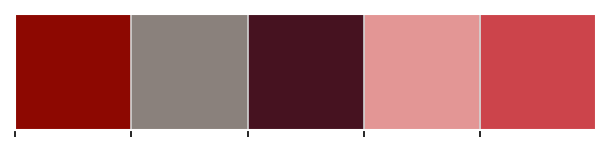

In [2]:
### Ignoring warnings
warnings.filterwarnings('ignore')

### Pandas Settings
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

### Visualization Settings
mpl.style.use('ggplot')

mpl.rcParams['figure.figsize']      = (20, 5)
mpl.rcParams['figure.titlesize']    = 25
mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['font.size']           = 12
mpl.rcParams['axes.grid']           = True
mpl.rcParams['figure.dpi']          = 150

### Palette Seting
instyle_palette = ['#8d0801', '#8a817c', '#461220', '#e39695', '#cc444b']
sns.set_palette(sns.color_palette(instyle_palette))
sns.palplot(sns.color_palette(instyle_palette))

### Random Seed
SEED = 42

### 0.3. Functions

In [3]:
##### Functions

def df_shape(df):
    """
    Summary: The function prints the number of rows and columns of a given DataFrame.

    Args:
        df: the DataFrame we want to know more about.
    
    Returns: a text indicating the number of rows and columns of the DataFrame.
    """

    print('Number of rows: {:,}'.format(df.shape[0]))
    print('Number of columns: {:,}'.format(df.shape[1]))

    return None

def set_image(title, xlabel, ylabel, xrotation=0, yrotation=0):
    """
    Summary: This function sets the image configuration.

    Args:
        title: the title of the plot.
        xlabel: the label for the x axis.
        ylabel: the label for the y axis.
        rotation: the rotation of the labels. default as 0.

    Returns: None
    """

    plt.title(title)
    plt.xlabel(xlabel, color='black')
    plt.ylabel(ylabel, color='black')
    plt.xticks(rotation=xrotation)
    plt.yticks(rotation=yrotation)
    plt.tick_params(left=False, bottom=False);

    return None

def classify_grades(grade):
    """
    Summary: This function transforms the grades into categories.

    Args: Grades.

    Returns: None
    """

    if grade in [0, 1, 2]:
        return 'Bad'
    elif grade == 3:
        return 'Regular'
    elif grade in [4, 5]:
        return 'Good'
    else:
        return 'NaN'
    
    return None

### Preprocessing

def renaming_columns(df):
    """
    Summary: This function transforms the column names to snake_case style.

    Args: Dataframe with incorrect column names.

    Returns: list of updated column names.
    """

    # List of columns
    old_columns = df.columns.tolist()
    # Lambda function
    snake_case = lambda x: inflection.underscore(x)
    # Apply the function to each column 
    new_columns = list(map(snake_case, old_columns))
    # Assigning new column names to DataFrame
    df.columns = new_columns

    # Iterate over each column name
    for column in df.columns:
        # Replacing spaces with underscores using regular expressions
        new_name = re.sub(r'\s+', '_', column)
        # Assigning the new name to columns
        df.rename(columns={column: new_name}, inplace=True)

    # Some columns need to be renamed manually
    mapping = {'open/close_time_convenient': 'open_close_time_convenient', 'showroom_': 'showroom'}

    # Rename the columns
    df.rename(columns=mapping, inplace=True)

    # Display the updated column names
    
    return df.columns.tolist()

### Feature Engineering

def columns_encoder(df):
    """
    Summary: This function was created to encode the columns. 
    First step is a list of columns, then creating dictionaries and applying them to the columns through the map function inside the for loop.

    Args: Dataframe with columns to be encoded.

    Returns: None
    """

    # Setting the columns for encoding
    encoding_columns        = ['gender', 'customer_type', 'type_of_purchase', 'store_size', 'satisfaction']

    # Creating Dictionaries
    gender_dict             = {'Male': 0, 'Female': 1}
    customer_type_dict      = {'Loyal Customer': 0, 'disloyal Customer': 1}
    type_of_purchase_dict   = {'Gift': 0, 'Personal': 1}
    store_size_dict         = {'Small': 0, 'Medium': 1, 'Large': 2}
    satisfaction_dict       = {'Neutral or Dissatisfaction': 0, 'Satisfied': 1}

    dictionaries            = [gender_dict, customer_type_dict, type_of_purchase_dict, store_size_dict, satisfaction_dict]

    # Applying the dictionaries
    for column, dict in zip(encoding_columns, dictionaries):
        try:
            df[column] = df[column].map(dict)
        except KeyError:
            pass
        except ValueError:
            continue

    return None

def knn_imputer(df, n_neighbors=5):
    """
    Summary: This function imputes missing values through KNN-Imputer.

    Args: Dataframe and number of neighbors (default as 5).

    Returns: imputed dataframe.
    """

    # Creating KNN imputer 
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Fitting and transforming the dataframe
    df_imputed = imputer.fit_transform(df)

    # Converting the imputed data back to a DataFrame
    df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

    return df_imputed

def scaling_columns(df, columns, scaler):
    """
    Summary: This function was created to scale the columns faster and easier.

    Args: Dataframe, list of columns and scaler.

    Returns: Dataframe with scaled columns.
    """
    # Fit and transform the specified columns
    df[columns] = scaler.fit_transform(df[columns].values)
    
    return df

### Machine Learning

def model_report(model_name,y_test, y_pred):
    """
    Summary: This function was created to print the metrics of each model. 
    The metrics include Accuracy, Precision, Recall, F1 Score and Classification Report.

    Args: Model name, values for y_test and y_pred.

    Returns: None
    """

    print('Model Name:', model_name)
    print('Accuracy:',  np.round(accuracy_score(y_test, y_pred), 4))
    print('Precision:', np.round(precision_score(y_test, y_pred), 4))
    print('Recall:',    np.round(recall_score(y_test, y_pred), 4))
    print('F1 Score:',  np.round(f1_score(y_test, y_pred), 4))
    print('Classification Report: \n', classification_report(y_test, y_pred))

    return None

def CM(title, y_test, y_pred):
    """
    Summary: This function prints the Confusion Matrix for each model.

    Args: title for the plot, values for y_test and y_pred of the model.

    Returns: None
    """
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Customizing the plot
    labels = ['Neutral or Dissatisfied', 'Satisfied']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Reds', values_format='d')  

    # Image Settings    
    plt.title(title)
    plt.xlabel('Predicted Label', color='black')
    plt.ylabel('True Label', color='black')
    plt.yticks(rotation=90, ha='right')
    plt.tick_params(left=False, bottom=False);
     
    return None

def CV(model, X, y, splits = 5, threshold=0.5):
    """
    Summary: This function is used to create Cross Validation for each model.

    Args: Model, X data, y values, number of splits (default = 5) and threshold (default = 0.5).

    Returns: results
    """
    
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'}

    kf = StratifiedKFold(n_splits = splits, shuffle = True, random_state = SEED )
    
    scores = cross_validate(model, X, y, cv = kf, scoring=['accuracy','precision','recall','f1'], return_train_score=True)

    y_prob      = cross_val_predict(model, X, y, cv = kf, method = 'predict_proba', verbose = False)
    y_prob      = y_prob[:,1]  
    y_pred      = (y_prob >= threshold).astype(int)

    results = {
        'scores': scores,
        'y_prob': y_prob,
        'y_pred': y_pred}

    return results

def CV_metrics(model_name, results):
    """
    Summary: This function prints the metrics for the cross validation test.

    Args: Model name and cross validation results.

    Returns: None
    """

    print('Model Name:',    model_name)
    print('Accuracy:',      results['scores']['test_accuracy'].mean())
    print('Precision:',     results['scores']['test_precision'].mean())
    print('Recall:',        results['scores']['test_recall'].mean())
    print('F1 Score:',      results['scores']['test_f1'].mean())

    return None

### 0.4. Loading data

In [4]:
# Importing the dataset as a DataFrame
df = pd.read_csv('../data/raw/instyle_dataset.csv')

## 1. Data description

In [5]:
df.head()

,id,Gender,Customer Type,Age,Type of Purchase,Store size,Store distance,InStore wifi,Open/Close time convenient,Easy of online shopping,Store location,Toilet cleaning,Dressing room,Waiting room,Kids entertainment,Seller service,Showroom,Self-Store,Purchase service,Store Service,Cleanliness,Carrier delay in minutes,Delivery delay in minutes,Satisfaction
0,70172,Male,Loyal Customer,13,Personal,Small,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.000,Neutral or Dissatisfaction
1,5047,Male,disloyal Customer,25,Gift,Large,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.000,Neutral or Dissatisfaction
2,110028,Female,Loyal Customer,26,Gift,Large,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.000,Satisfied
3,24026,Female,Loyal Customer,25,Gift,Large,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.000,Neutral or Dissatisfaction
4,119299,Male,Loyal Customer,61,Gift,Large,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.000,Satisfied


### 1.1. Data Dimensions

In [6]:
df_shape(df)

Number of rows: 129,880
Number of columns: 24


### 1.2. Columns

| Nome da Coluna              | Descrição                               |
| -------------------------- | --------------------------------------- |
| `id`                         | ID do cliente                           |
| `Gender`                     | Gênero do cliente                       |
| `Customer Type`              | Tipo de cliente (leal ou não)   |
| `Age`                        | Idade do cliente                        |
| `Type of Purchase`           | Tipo de compra (pessoal ou presente) |
| `Store size`                 | Tamanho da loja                         |
| `Store distance`             | Distância da loja em relação ao cliente  |
| `InStore wifi`               | Disponibilidade de WiFi na loja         |
| `Open/Close time convenient` | Conveniência dos horários de abertura/fechamento |
| `Easy of online shopping`    | Facilidade na experiência de compra online |
| `Store location`             | Localização da loja                     |
| `Toilet cleaning`            | Qualidade da limpeza do banheiro        |
| `Dressing room`              | Disponibilidade e qualidade do provador |
| `Waiting room`               | Presença e qualidade da sala de espera  |
| `Kids entertainment`         | Disponibilidade de entretenimento para crianças |
| `Seller service`             | Qualidade do serviço do vendedor        |
| `Showroom`                   | Presença e qualidade do showroom       |
| `Self-Store`                 | Disponibilidade e qualidade das opções de autoatendimento |
| `Purchase service`           | Qualidade do serviço de compra          |
| `Store Service`              | Qualidade geral do serviço da loja     |
| `Cleanliness`                | Limpeza da loja                        |
| `Carrier delay in minutes`   | Atraso nos serviços de transporte em minutos |
| `Delivery delay in minutes`  | Atraso nos serviços de entrega em minutos |
| `Satisfaction`               | Nível de satisfação do cliente         |



### 1.3. Data Types

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          129880 non-null  int64  
 1   Gender                      129880 non-null  object 
 2   Customer Type               129880 non-null  object 
 3   Age                         129880 non-null  int64  
 4   Type of Purchase            129880 non-null  object 
 5   Store size                  129880 non-null  object 
 6   Store distance              129880 non-null  int64  
 7   InStore wifi                129880 non-null  int64  
 8   Open/Close time convenient  129880 non-null  int64  
 9   Easy of online shopping     129880 non-null  int64  
 10  Store location              129880 non-null  int64  
 11  Toilet cleaning             129880 non-null  int64  
 12  Dressing room               129880 non-null  int64  
 13  Waiting room  

In [8]:
# Displaying columns set as Object
df.select_dtypes('object').columns.to_list()

['Gender', 'Customer Type', 'Type of Purchase', 'Store size', 'Satisfaction']

## 2. Preprocessing and Data Exploration

### 2.1. Renaming Columns

In [9]:
# Renaming dataset columns
renaming_columns(df)

['id',
 'gender',
 'customer_type',
 'age',
 'type_of_purchase',
 'store_size',
 'store_distance',
 'in_store_wifi',
 'open_close_time_convenient',
 'easy_of_online_shopping',
 'store_location',
 'toilet_cleaning',
 'dressing_room',
 'waiting_room',
 'kids_entertainment',
 'seller_service',
 'showroom',
 'self_store',
 'purchase_service',
 'store_service',
 'cleanliness',
 'carrier_delay_in_minutes',
 'delivery_delay_in_minutes',
 'satisfaction']

### 2.2. Checking NaN

In [10]:
# Checking for null values
null_values = pd.DataFrame(
    {'NA': df.isna().sum(), 
    '%NA': (df.isna().sum()) / (df.shape[0]) * (100)}
).sort_values('NA', ascending=False)

# Displaying the null values
null_values

,NA,%NA
delivery_delay_in_minutes,393,0.303
id,0,0.000
gender,0,0.000
carrier_delay_in_minutes,0,0.000
cleanliness,0,0.000
store_service,0,0.000
purchase_service,0,0.000
self_store,0,0.000
showroom,0,0.000
seller_service,0,0.000


### 2.3. Checking data balance

In [11]:
# Checking data balance
balance = pd.DataFrame(
    {'Total' : df['satisfaction'].value_counts(), 
    '% Pct.' : df['satisfaction'].value_counts(normalize=True) * 100}
).sort_values('Total', ascending=False)

# Displaying data balance
balance

,Total,% Pct.
Neutral or Dissatisfaction,71897,55.356
Satisfied,57983,44.644


### 2.4. Numerical Data

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,129880.000,64940.500,37493.271,1.000,32470.750,64940.500,97410.250,129880.000
age,129880.000,39.428,15.119,7.000,27.000,40.000,51.000,85.000
store_distance,129880.000,1190.316,997.452,31.000,414.000,844.000,1744.000,4983.000
in_store_wifi,129880.000,2.729,1.329,0.000,2.000,3.000,4.000,5.000
open_close_time_convenient,129880.000,3.058,1.527,0.000,2.000,3.000,4.000,5.000
easy_of_online_shopping,129880.000,2.757,1.402,0.000,2.000,3.000,4.000,5.000
store_location,129880.000,2.977,1.279,0.000,2.000,3.000,4.000,5.000
toilet_cleaning,129880.000,3.205,1.330,0.000,2.000,3.000,4.000,5.000
dressing_room,129880.000,3.253,1.351,0.000,2.000,3.000,4.000,5.000
waiting_room,129880.000,3.441,1.319,0.000,2.000,4.000,5.000,5.000


### 2.5. Categorical Data

In [13]:
# Categorical attributes
cat_attributes = df.select_dtypes(include=['object'])

# Values
cat_attributes.apply(lambda x: x.unique().shape[0])

gender              2
customer_type       2
type_of_purchase    2
store_size          3
satisfaction        2
dtype: int64

In [14]:
for col in cat_attributes.describe(include = 'all').columns:
    print(col)
    print(cat_attributes[col].unique())
    print()

gender
['Male' 'Female']

customer_type
['Loyal Customer' 'disloyal Customer']

type_of_purchase
['Personal' 'Gift']

store_size
['Small' 'Large' 'Medium']

satisfaction
['Neutral or Dissatisfaction' 'Satisfied']



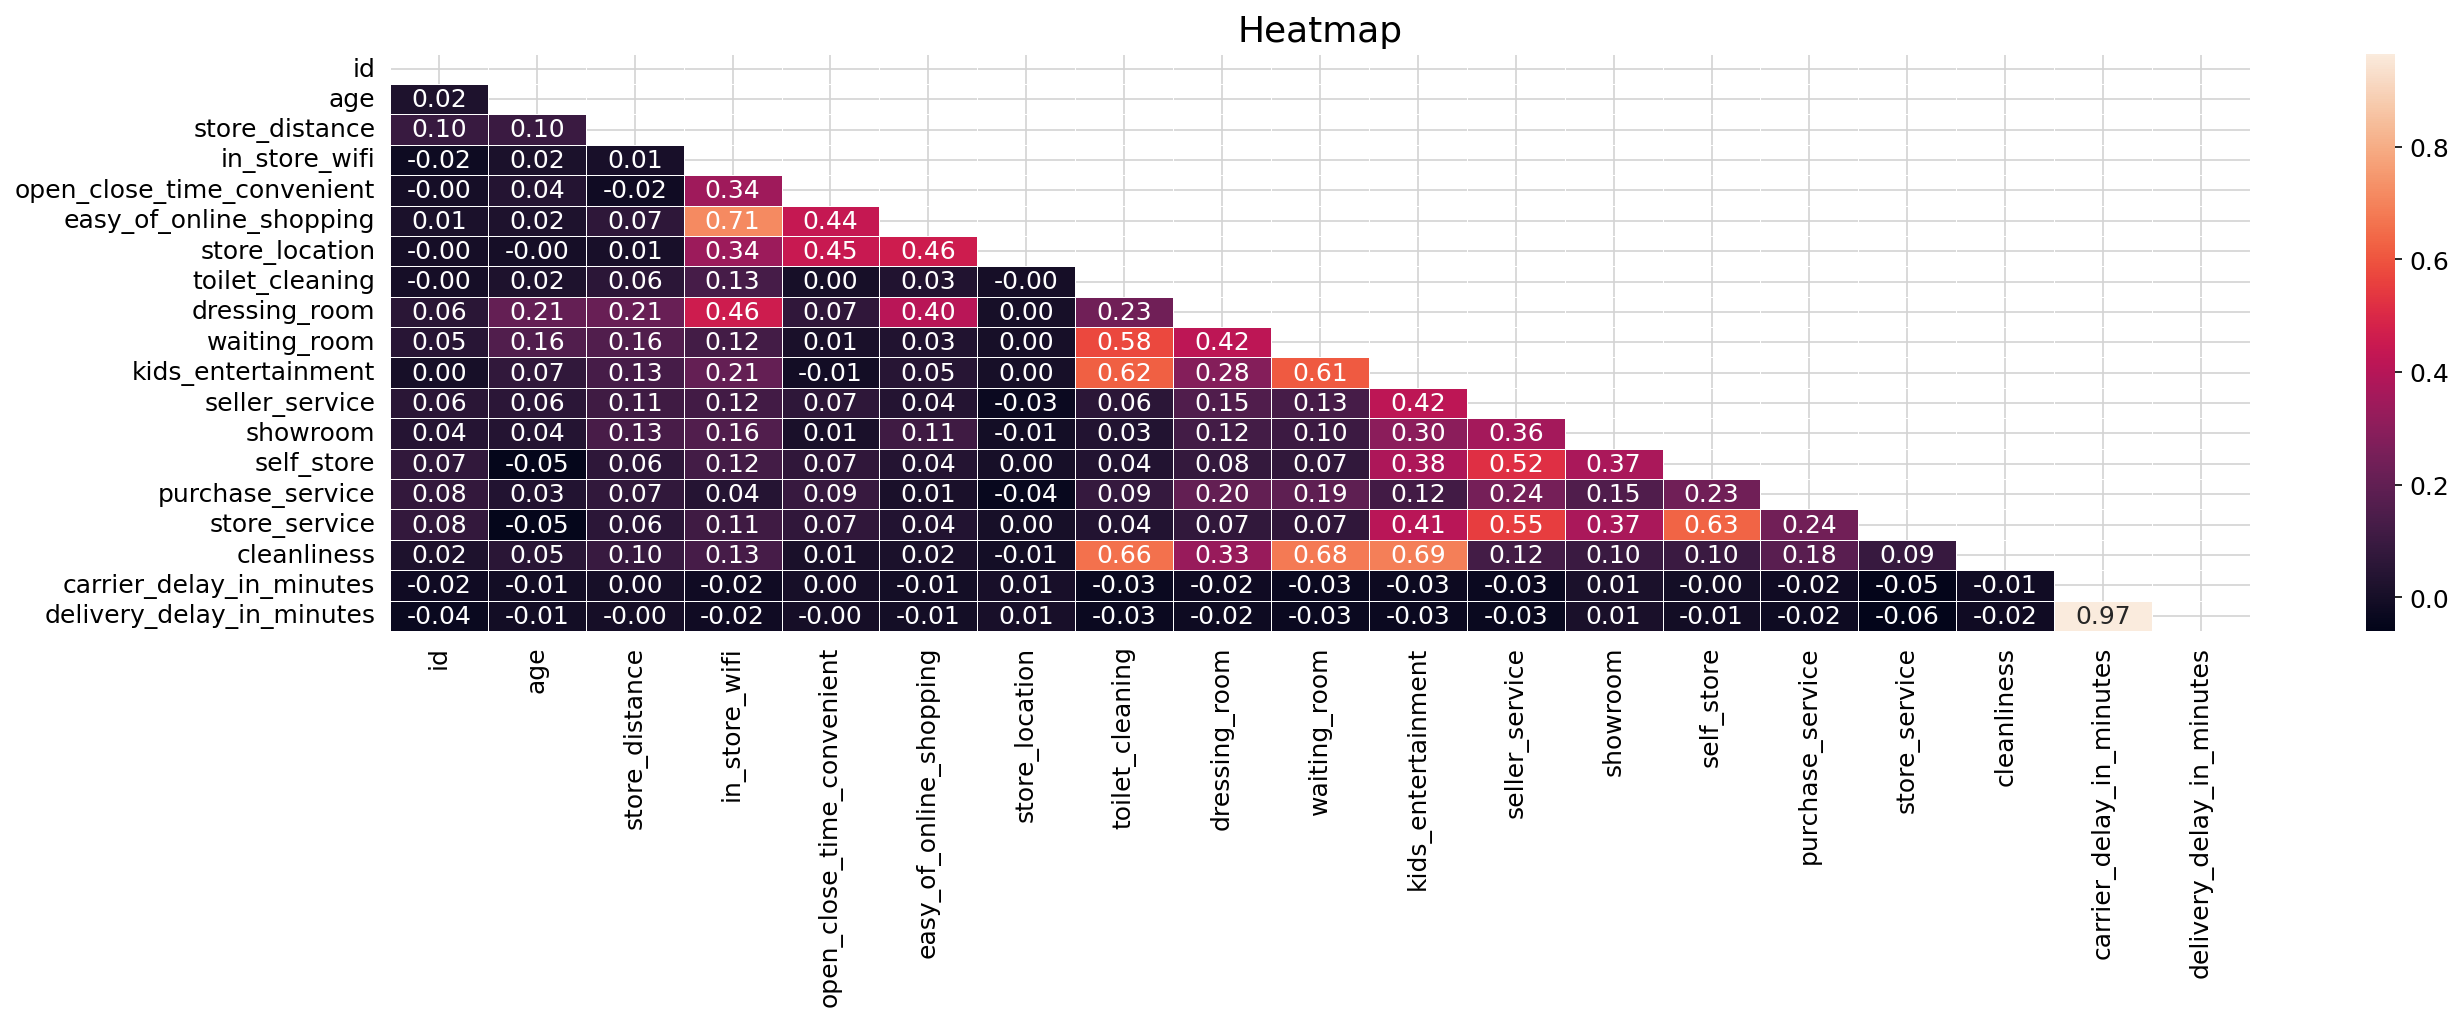

In [15]:
# Mask to remove the upper triangle
mask = np.zeros_like(df.corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

# Correlation
correlation = df.corr(method='pearson')

# Heatmap
sns.heatmap(correlation,linewidths=0.25,fmt=".2f", annot=True, mask=mask)

# Settings for plot
set_image('Heatmap', None, None, 90)

## 3. Exploratory Data Analysis

### 3.1. What is the proportion of satisfied and unsatisfied clients?

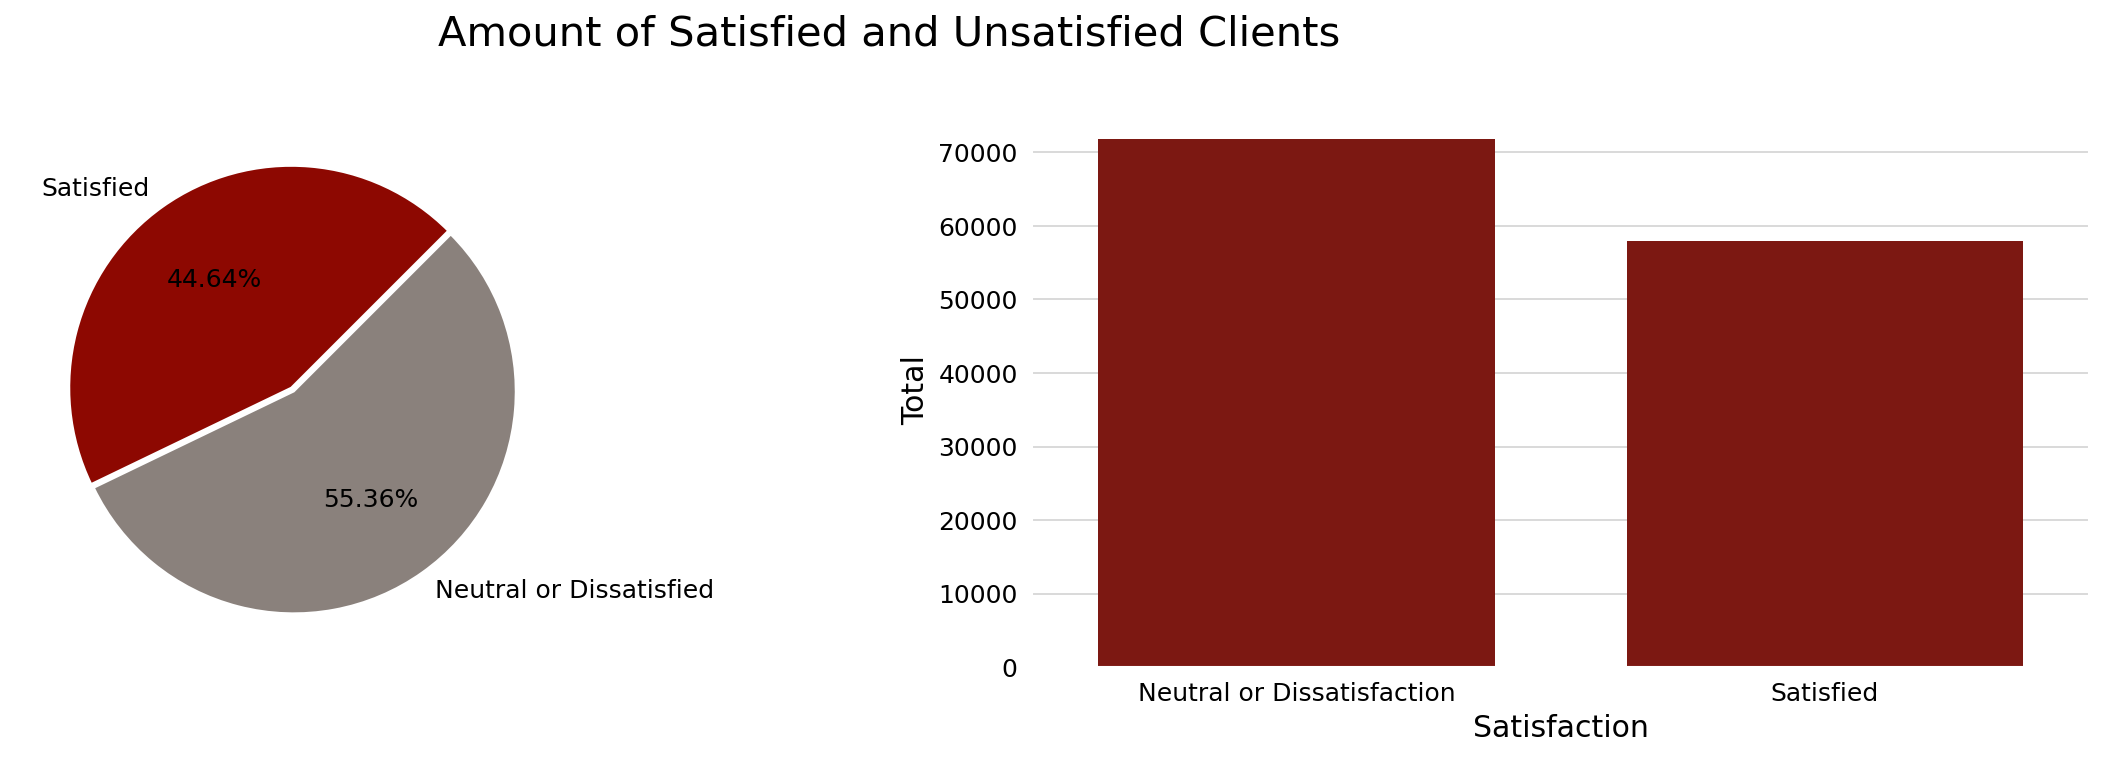

In [16]:
# Crating Figure
fig1, axes = plt.subplots(1,2)

# Plot 1
plt.subplot(1,2,1)
ax1 = plt.pie(([df['satisfaction'].value_counts()[1], df['satisfaction'].value_counts()[0]]), 
                labels=['Satisfied', 'Neutral or Dissatisfied'],
                explode=(0.01, 0.01),
                startangle=45,
                autopct='%.2f%%',
                wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
                textprops={'fontsize': 12},
                labeldistance=1.1)
set_image(None, None, None)

# Plot 2
plt.subplot(1,2,2)
ax2 = sns.countplot(data = df, x = 'satisfaction', width=0.75)
set_image(None, 'Satisfaction', 'Total')

# Title for the main plot
fig1.suptitle('Amount of Satisfied and Unsatisfied Clients', fontsize=20)

# Adjusting the space
fig1.subplots_adjust(top=0.85)

### 3.2. What is the gender distribution of the clients? Does the gender affect the satisfaction level?

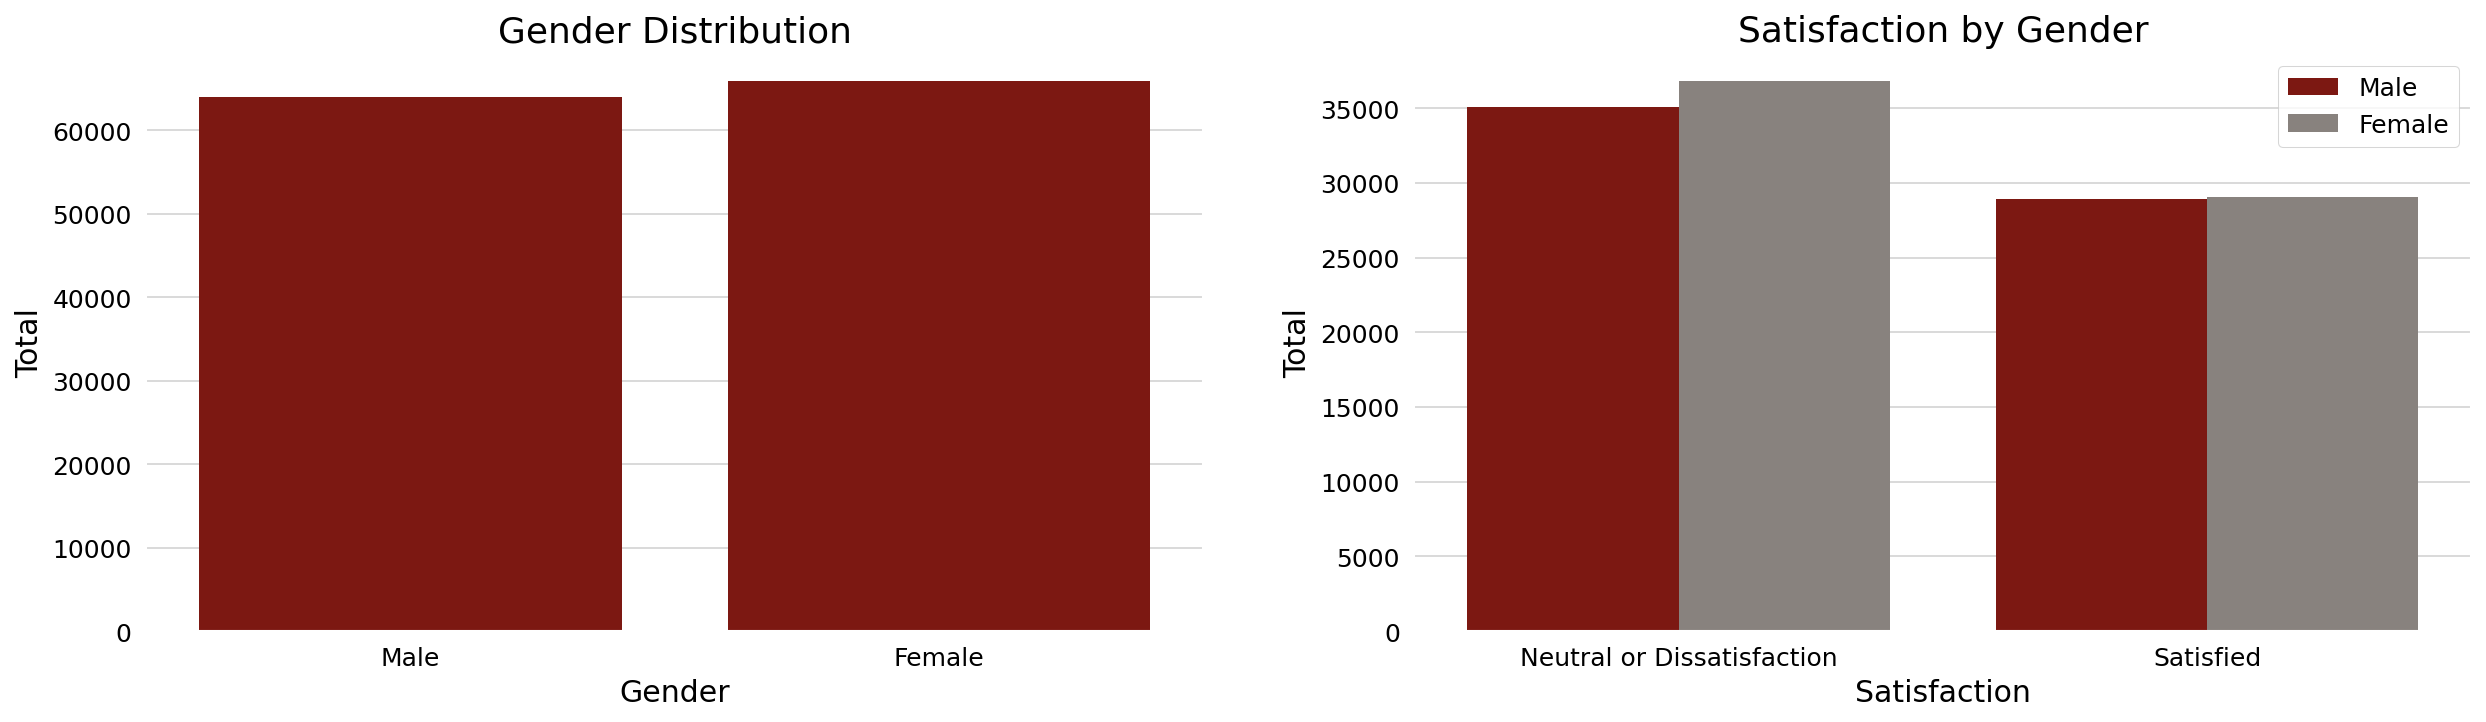

In [17]:
# Crating Figure
fig2, axes = plt.subplots(1,2)

# Plot 1 - Amount of Male and Female Clients
plt.subplot(1,2,1)
ax1 = sns.countplot(data = df, x = 'gender')
set_image('Gender Distribution', 'Gender', 'Total')

# Plot 2 - Male and Female on Satisfaction
plt.subplot(1,2,2)
ax2 = sns.countplot(data = df, x = 'satisfaction', hue = 'gender')
plt.legend(title='')
set_image('Satisfaction by Gender', 'Satisfaction', 'Total')


### 3.3. Histogram for the distribution of 'age' to understand the age distribution of customers and their satisfaction level

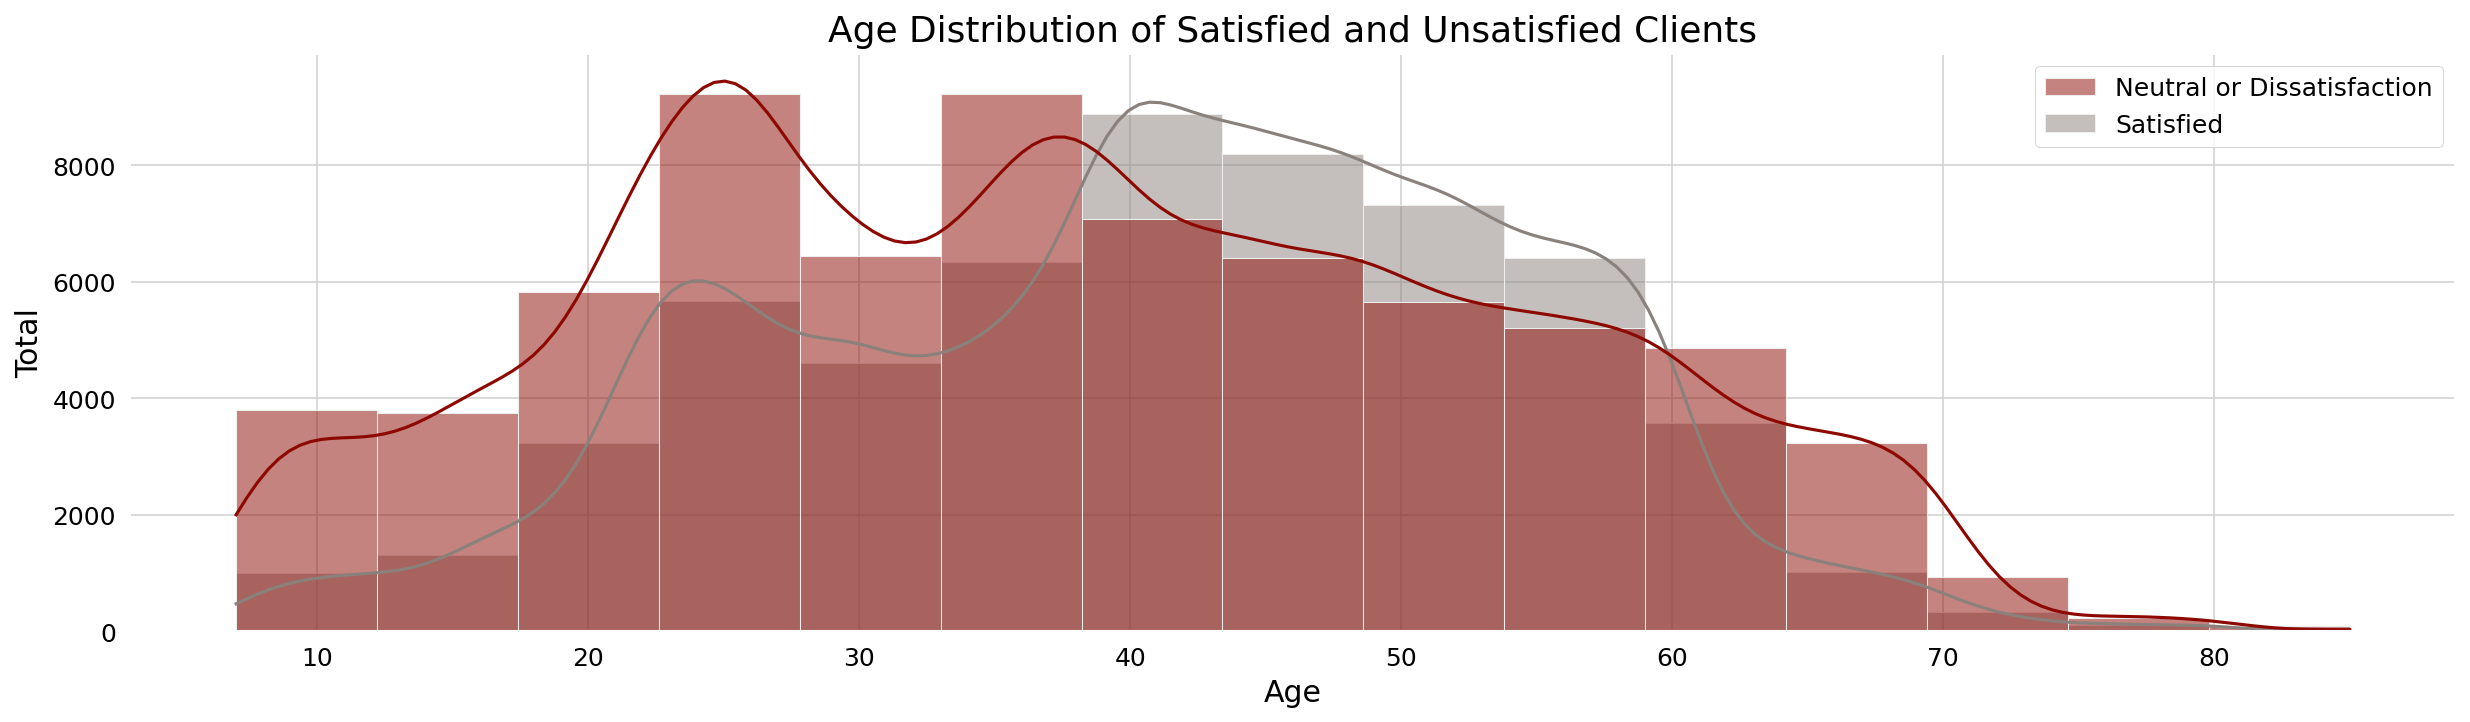

In [18]:
# Figure 
fig3 = sns.histplot(data = df, x = 'age', bins = 15, kde = True, hue='satisfaction', legend=True)
# Legend Settings
sns.move_legend(fig3, 'upper right', title=None)
# Settings for plot
set_image('Age Distribution of Satisfied and Unsatisfied Clients', 'Age', 'Total')

### 3.4. Does the type of purchase affect the satisfaction level?

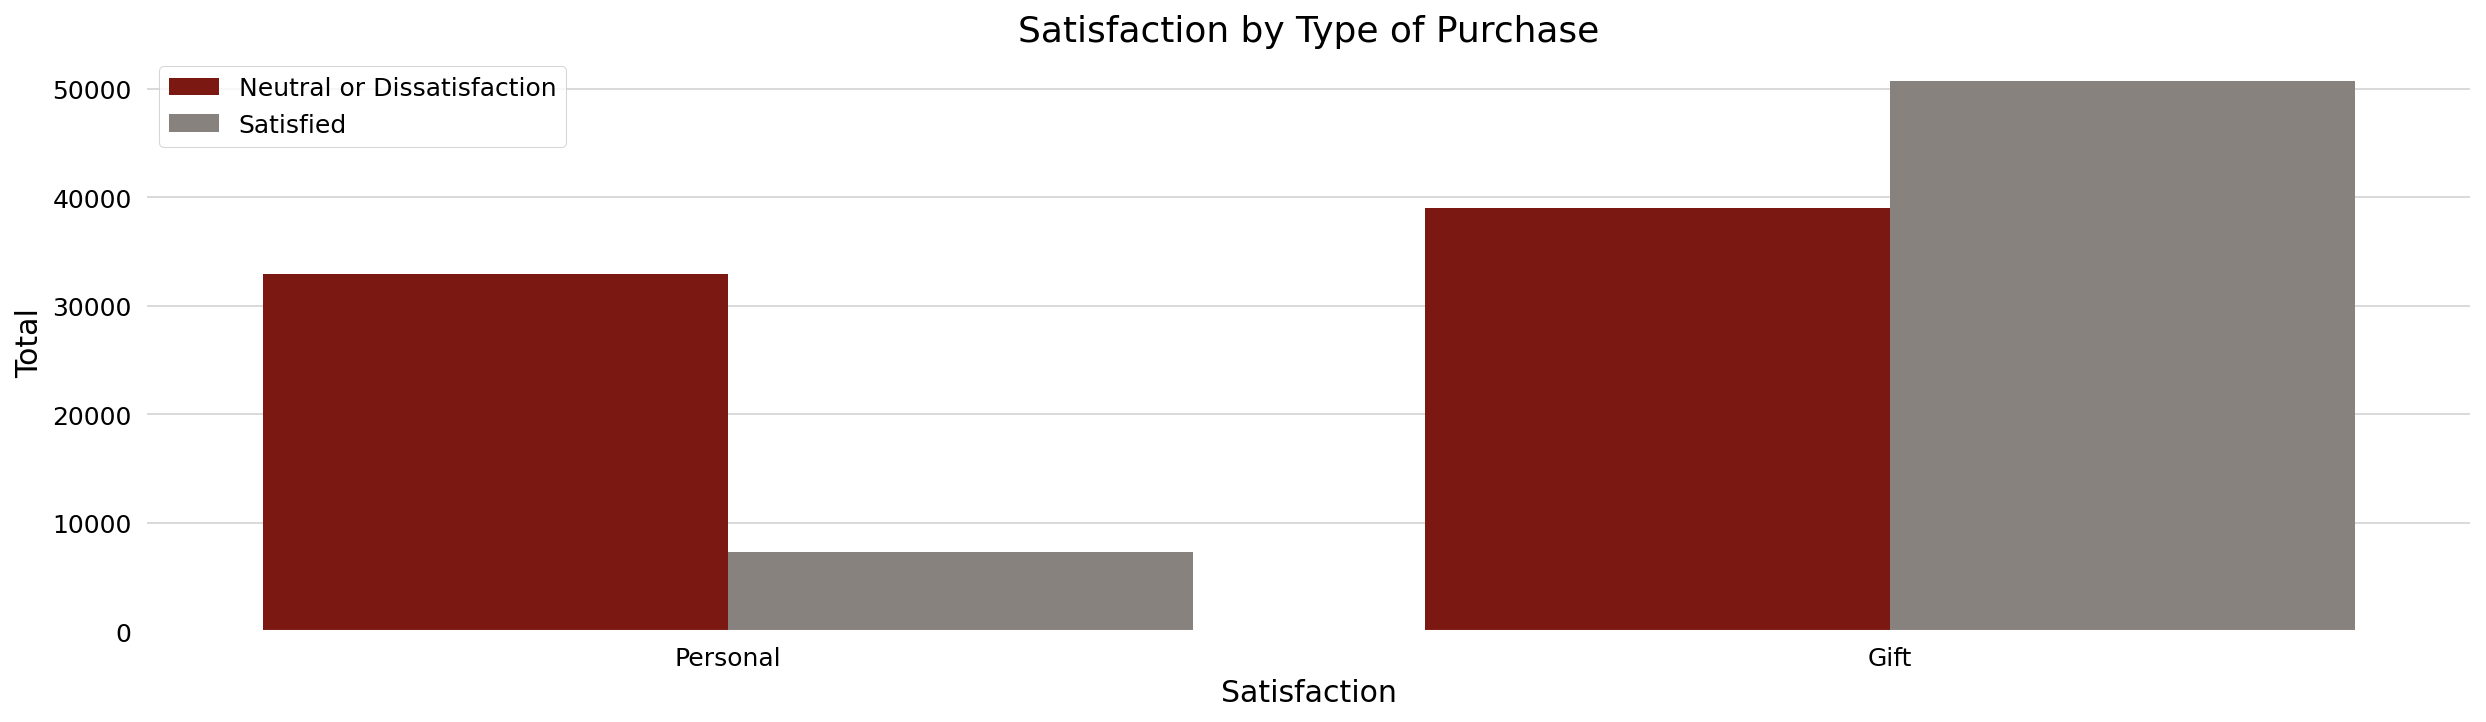

In [19]:
# Figure 
fig4 = sns.countplot(data=df, x='type_of_purchase', hue='satisfaction')
# Legend Settings
sns.move_legend(fig4, 'upper left', title=None)
# Settings for plot
set_image('Satisfaction by Type of Purchase', 'Satisfaction', 'Total')

### 3.5. How the services might impact on the satisfaction of the clients?

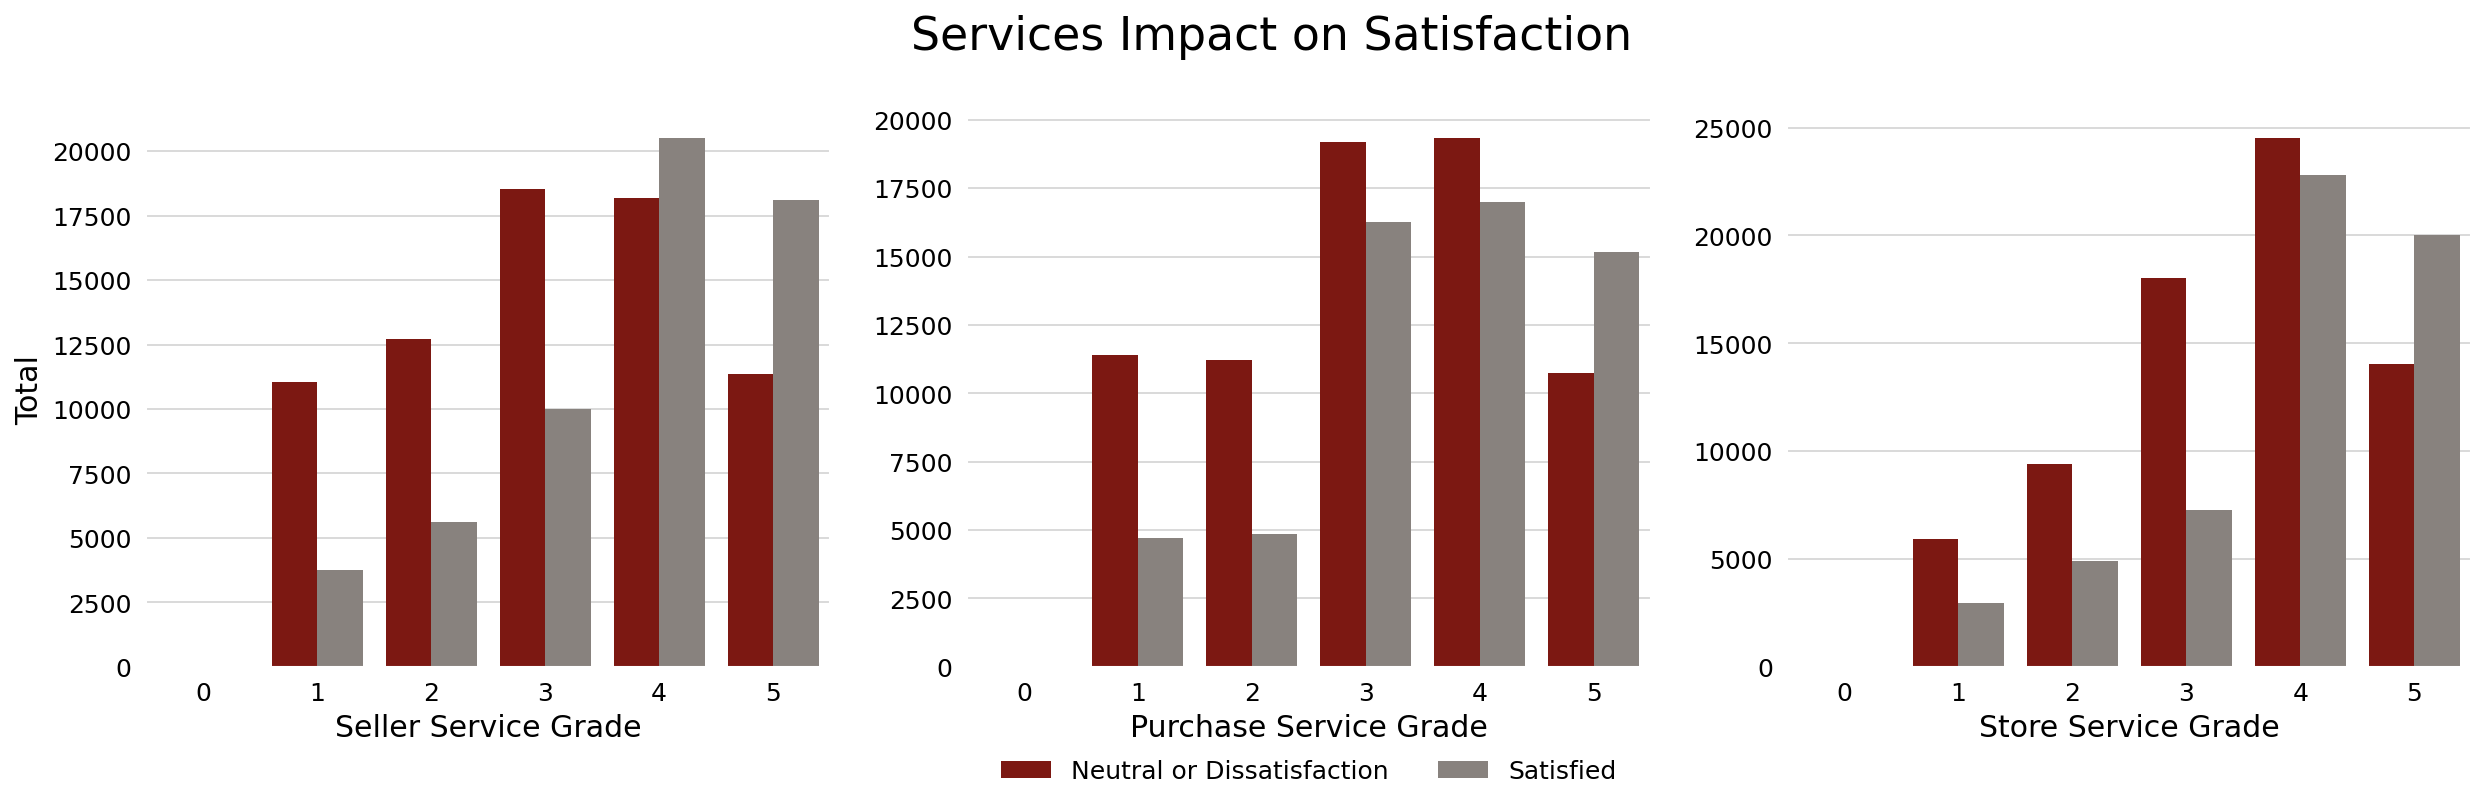

In [20]:
# Creating Figure
fig5, axes = plt.subplots(1,3)

order_hue = ['Neutral or Dissatisfaction', 'Satisfied']

# Plot 1
plt.subplot(1,3,1)
ax1 = sns.countplot(data = df, x = 'seller_service', hue = 'satisfaction', hue_order = order_hue, legend = False)
set_image(None, 'Seller Service Grade', 'Total')

# Plot 2
plt.subplot(1,3,2)
ax2 = sns.countplot(data = df, x = 'purchase_service', hue = 'satisfaction', hue_order = order_hue)
sns.move_legend(ax2, 'lower center', bbox_to_anchor=(0.5, -0.25), title = None, frameon = False, ncol = 2)
set_image(None, 'Purchase Service Grade', None)

# Plot 3
plt.subplot(1,3,3)
ax3 = sns.countplot(data = df, x = 'store_service', hue = 'satisfaction', hue_order = order_hue, legend = False)
set_image(None, 'Store Service Grade', None)

# Title for the main plot
fig5.suptitle('Services Impact on Satisfaction', fontsize=22)

# Adjusting the space
fig5.subplots_adjust(top=0.85)

### 3.6. Does the technology impact on the satisfaction of the clients?

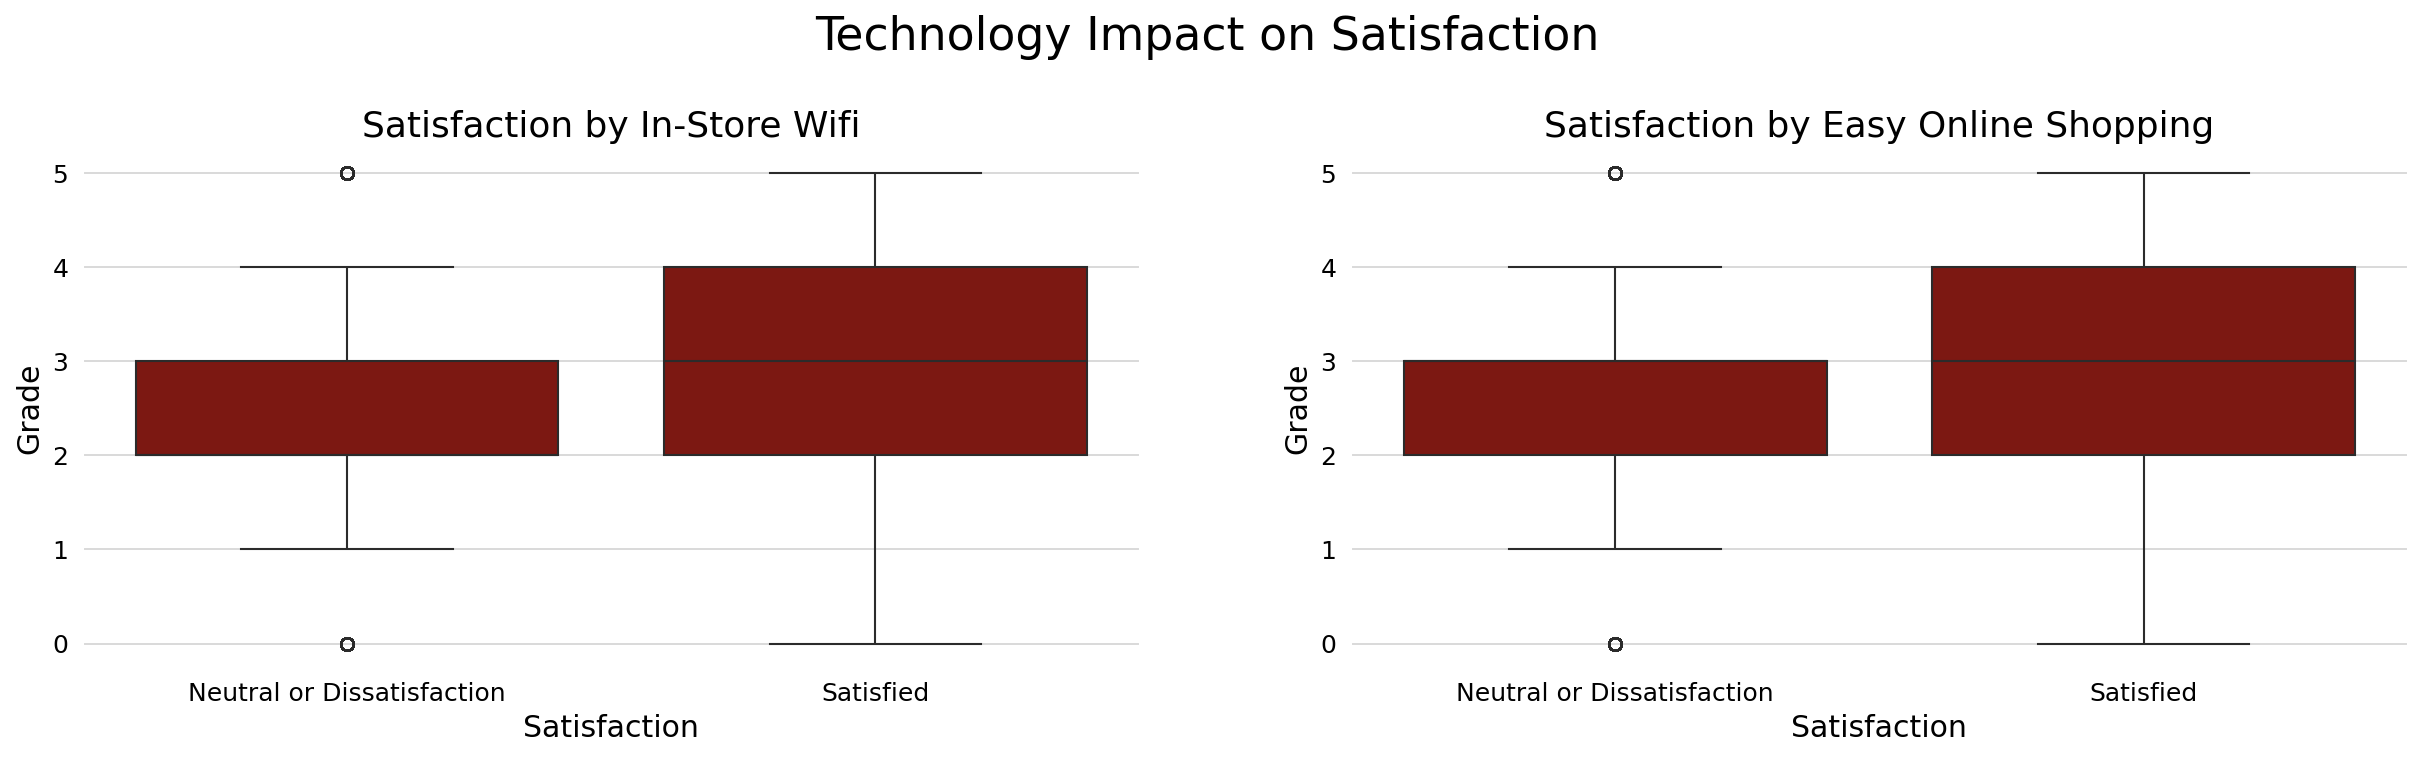

In [21]:
# Creating Figure
fig6, ax = plt.subplots(1,2)

# Plot 1
plt.subplot(1,2,1)
sns.boxplot(data = df, x = 'satisfaction', y = 'in_store_wifi')
set_image('Satisfaction by In-Store Wifi', 'Satisfaction', 'Grade')

# Plot 2
plt.subplot(1,2,2)
sns.boxplot(data = df, x = 'satisfaction', y = 'easy_of_online_shopping')
set_image('Satisfaction by Easy Online Shopping', 'Satisfaction', 'Grade')

# Title for the main plot
fig6.suptitle('Technology Impact on Satisfaction', fontsize=22)

# Adjusting the space
fig6.subplots_adjust(top=0.8)

### 3.7. Distribution of the distance from the store and their satisfaction

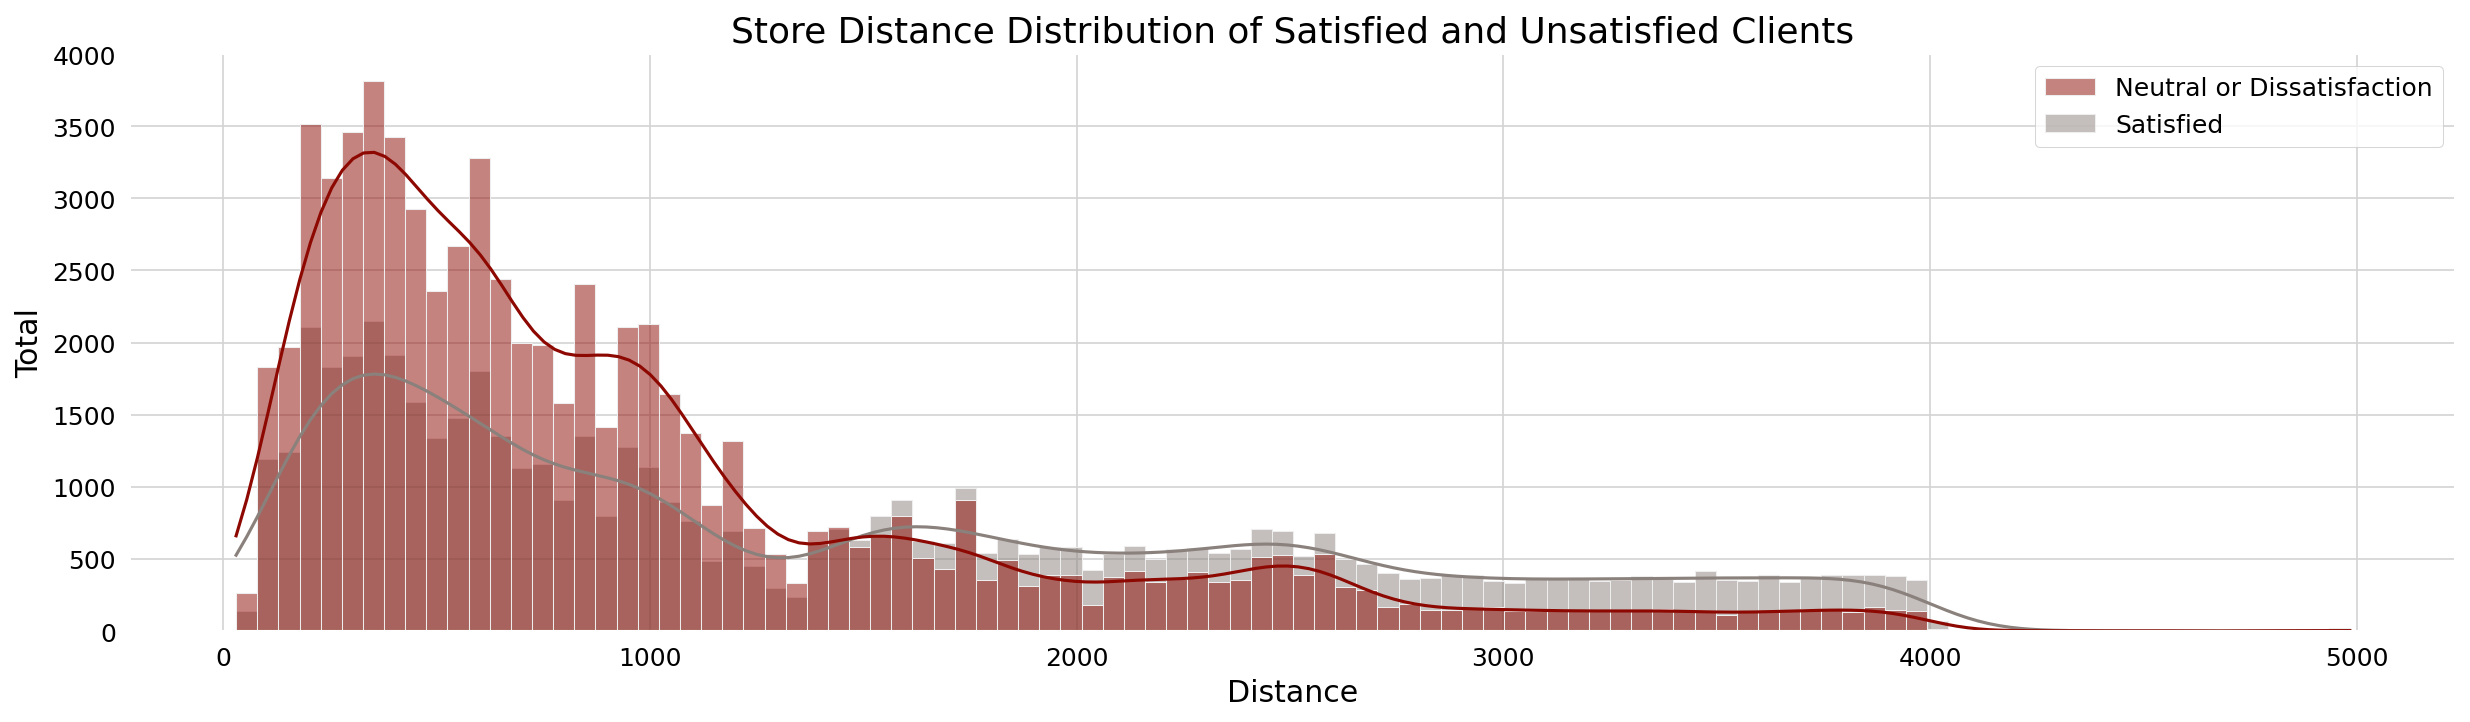

In [22]:
# Figure 
fig7 = sns.histplot(data = df, x = 'store_distance', bins = 100, kde = True, hue='satisfaction', legend=True)
# Legend Settings
sns.move_legend(fig7, 'upper right', title=None)
# Settings for plot
set_image('Store Distance Distribution of Satisfied and Unsatisfied Clients', 'Distance', 'Total')

### 3.8. General characteristics of the store and how they are related to satisfaction

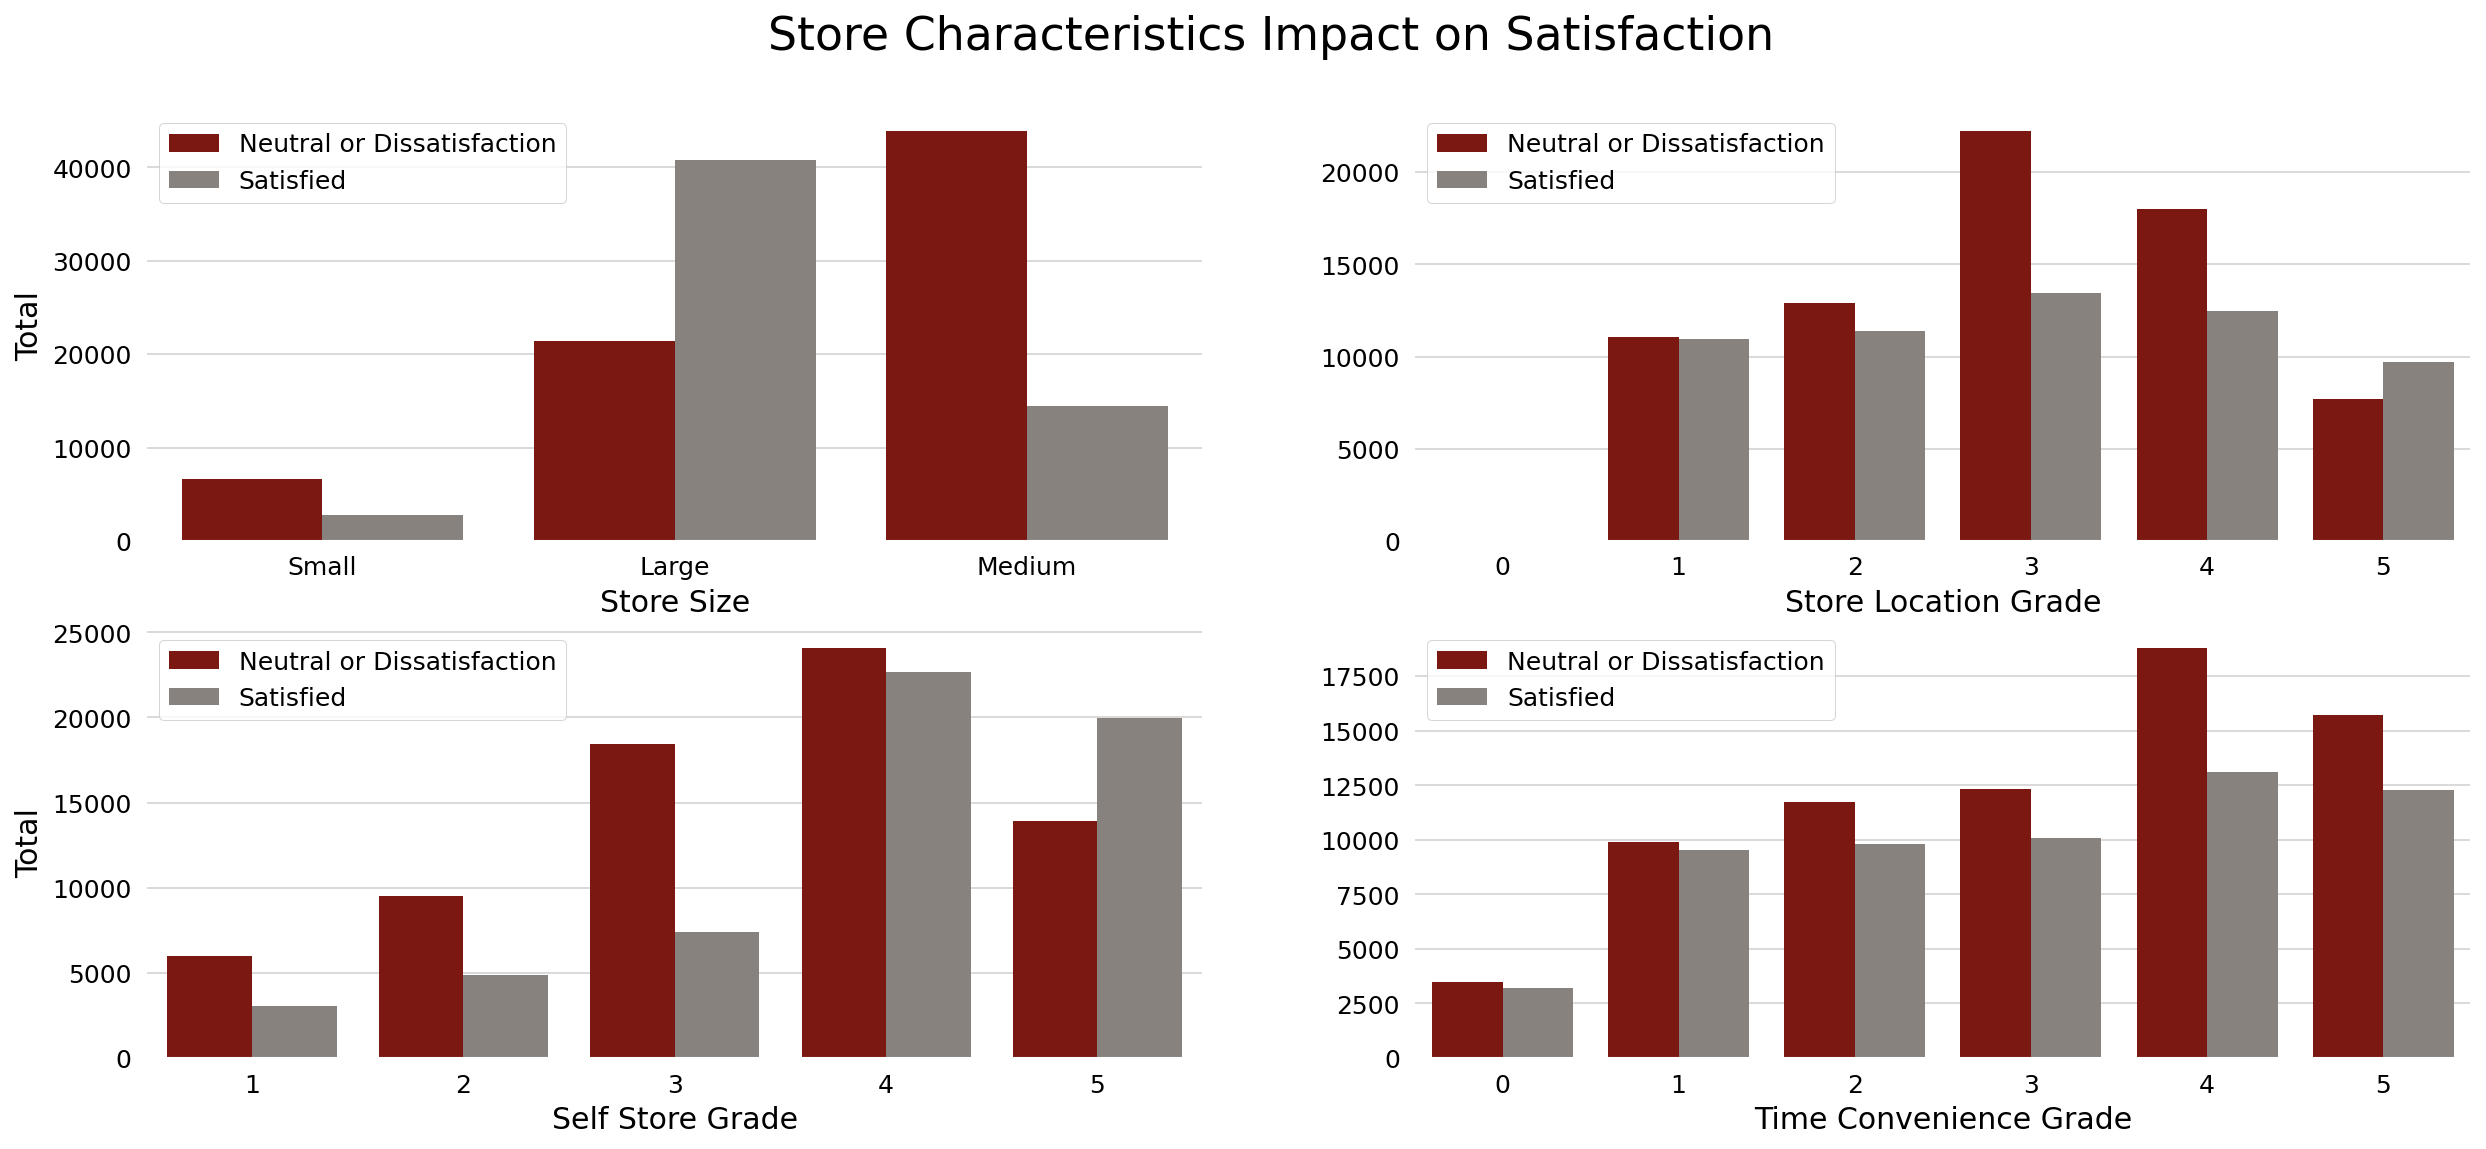

In [23]:
# Creating Figure
fig8, axes = plt.subplots(2, 2, figsize = (20, 8))

order_hue = ['Neutral or Dissatisfaction', 'Satisfied']

# Plot 1
plt.subplot(2, 2, 1)
ax1 = sns.countplot(data = df, x = 'store_size', hue = 'satisfaction', hue_order = order_hue)
sns.move_legend(ax1, 'upper left', title = None)
set_image(None, 'Store Size', 'Total')

# Plot 2
plt.subplot(2, 2, 2)
ax2 = sns.countplot(data = df, x = 'store_location', hue = 'satisfaction', hue_order = order_hue)
sns.move_legend(ax2, 'upper left', title = None)
set_image(None, 'Store Location Grade', None)

# Plot 3
plt.subplot(2, 2, 3)
ax3 = sns.countplot(data = df, x = 'self_store', hue = 'satisfaction', hue_order = order_hue)
sns.move_legend(ax3, 'upper left', title = None)
set_image(None, 'Self Store Grade', 'Total')

# Plot 4
plt.subplot(2, 2, 4)
ax4 = sns.countplot(data = df, x = 'open_close_time_convenient', hue = 'satisfaction', hue_order = order_hue)
sns.move_legend(ax4, 'upper left', title = None)
set_image(None, 'Time Convenience Grade', None)

# Title for the main plot
fig8.suptitle('Store Characteristics Impact on Satisfaction', fontsize=22)

# Adjusting the space
fig8.subplots_adjust(top=0.9)

### 3.9. Analysis of the customer type

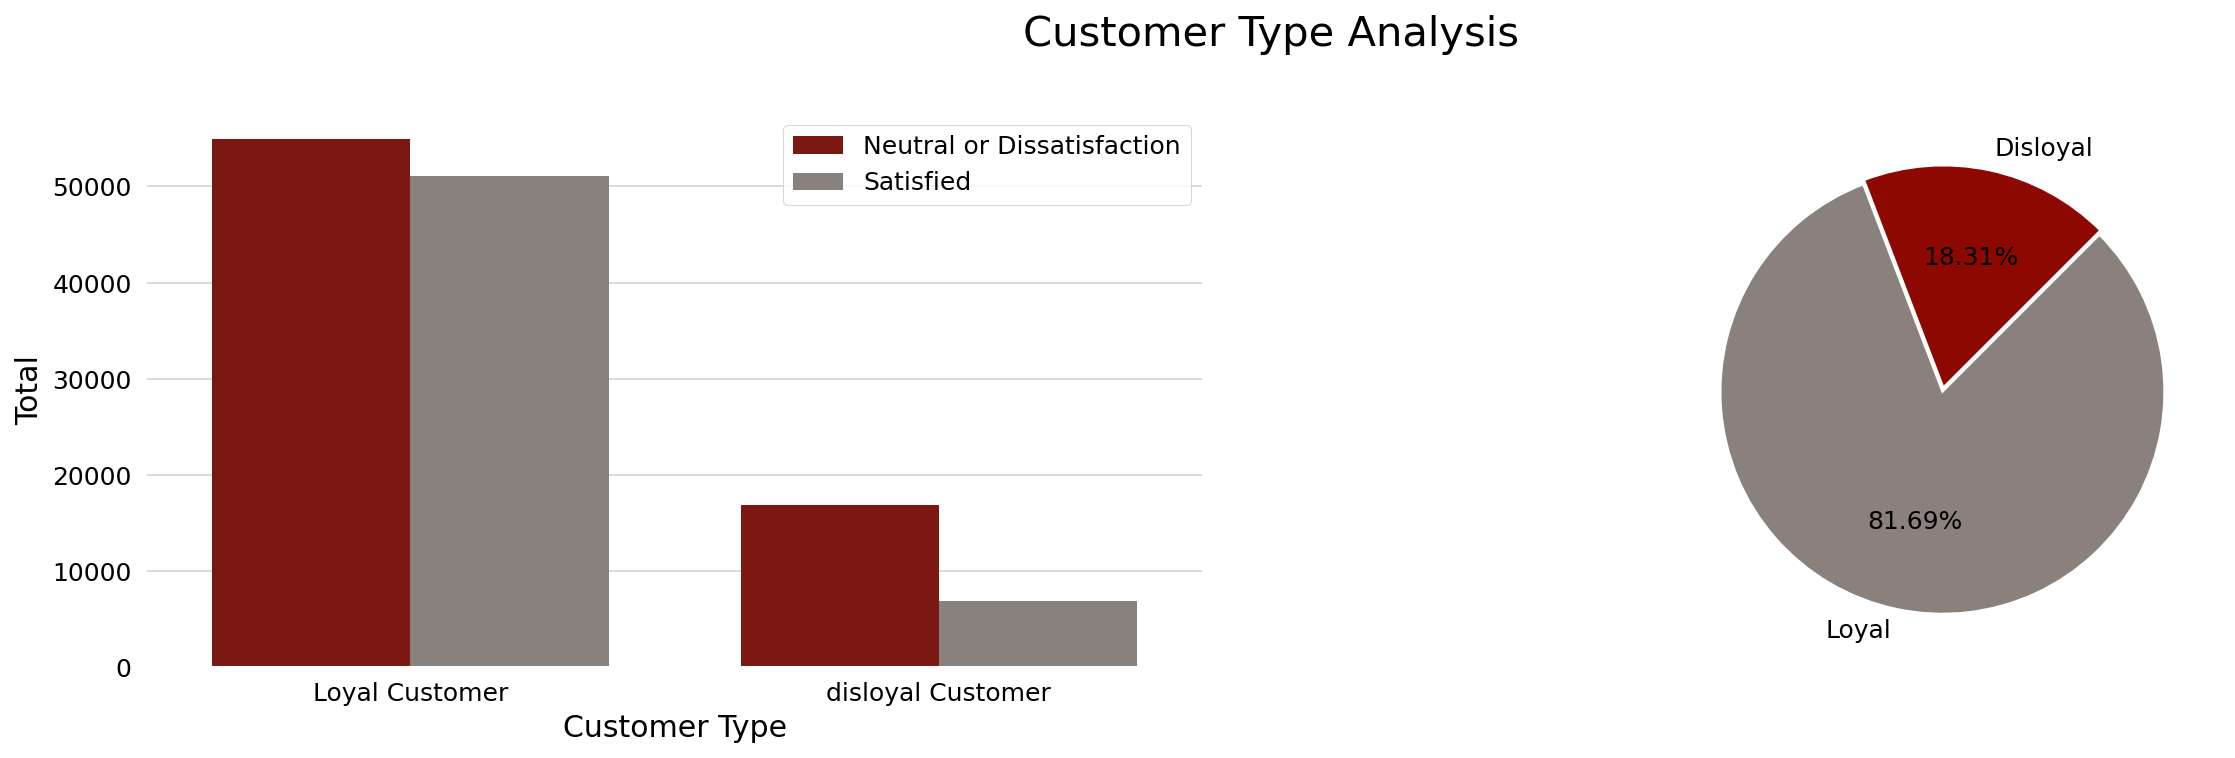

In [24]:
# Crating Figure
fig9, axes = plt.subplots(1,2)

# Plot 1
plt.subplot(1,2,1)
ax1 = sns.countplot(data = df, x = 'customer_type', hue = 'satisfaction', width=0.75)
sns.move_legend(ax1, 'upper right', title = None)
set_image(None, 'Customer Type', 'Total')

# Plot 2
plt.subplot(1,2,2)
ax2 = plt.pie(([df['customer_type'].value_counts()[1], df['customer_type'].value_counts()[0]]), 
                labels=['Disloyal', 'Loyal'],
                explode=(0.01, 0.01),
                startangle=45,
                autopct='%.2f%%',
                wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
                textprops={'fontsize': 12},
                labeldistance=1.1)
set_image(None, None, None)

# Title for the main plot
fig9.suptitle('Customer Type Analysis', fontsize=20)

# Adjusting the space
fig9.subplots_adjust(top=0.85)

### 3.10. Does the cleanliness affect the customer satisfaction?

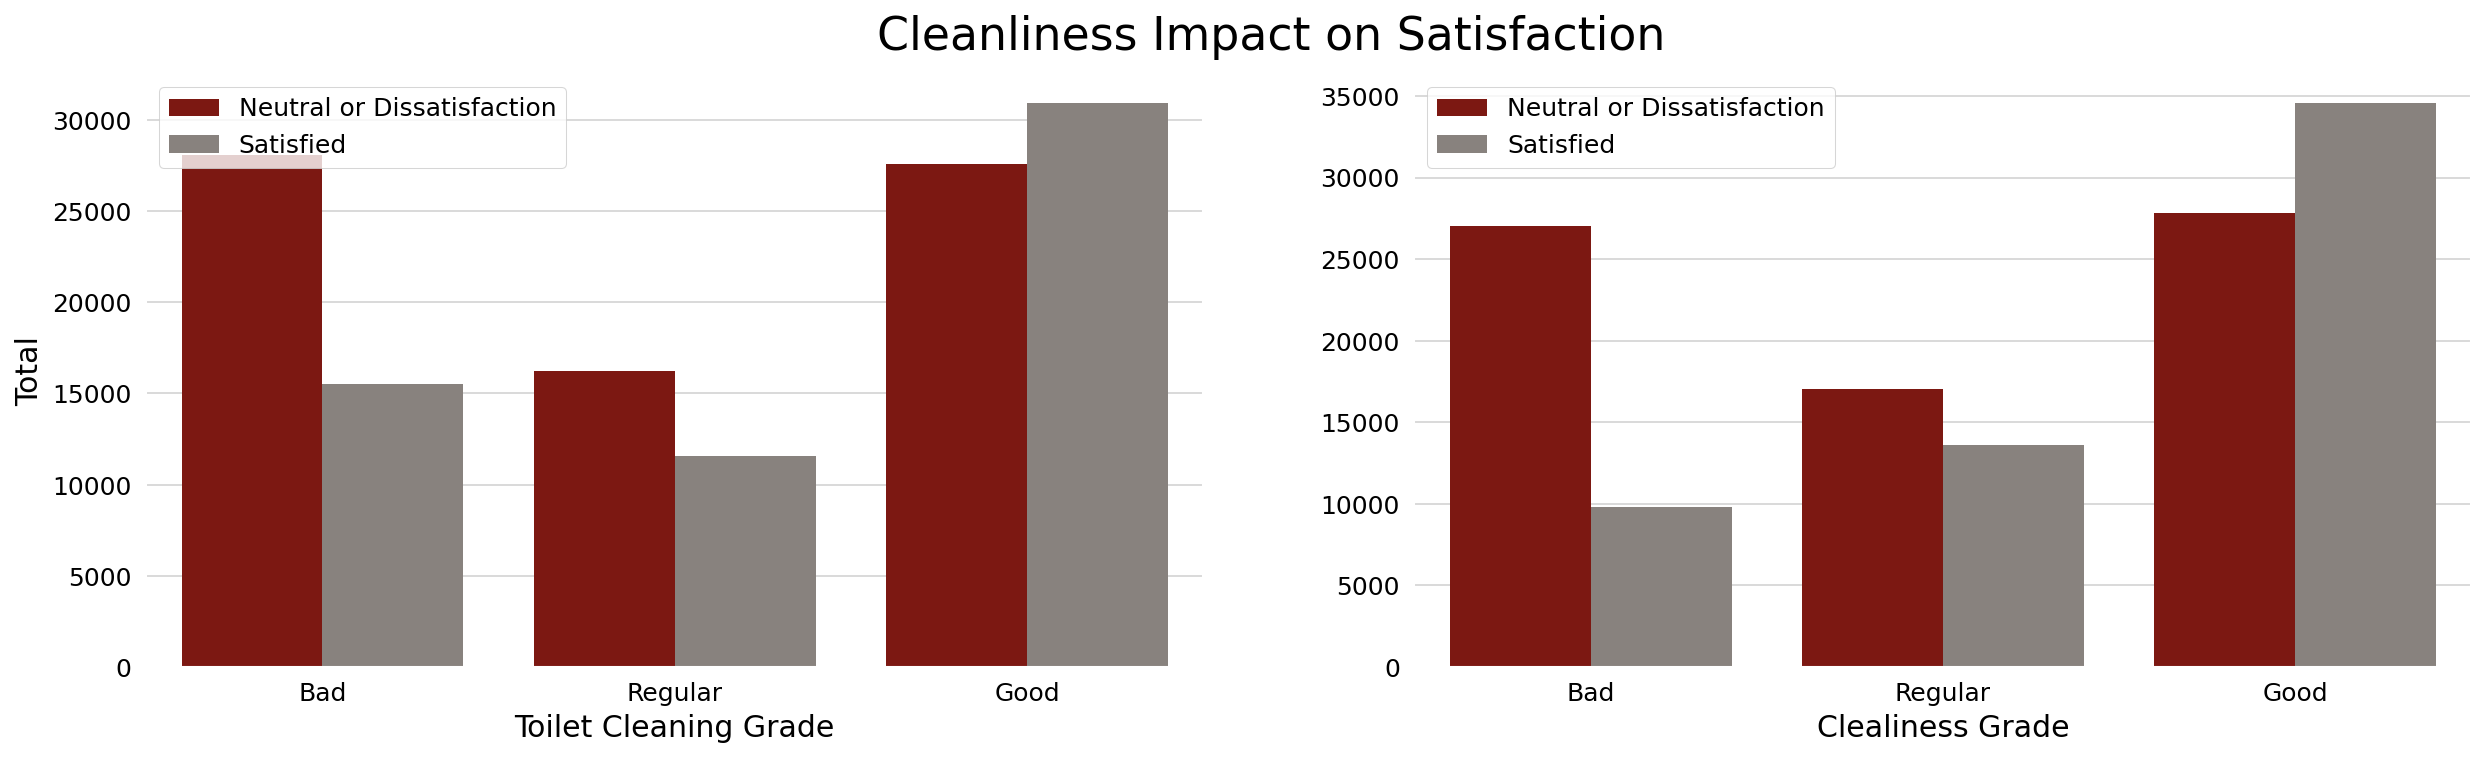

In [25]:
# Creating Figure
fig10, axes = plt.subplots(1,2)

order_hue = ['Neutral or Dissatisfaction', 'Satisfied']

# Data manipulation
df_plot = df.copy()

columns_plot = ['toilet_cleaning', 'cleanliness']

for column in columns_plot:
    df_plot[column] = df_plot[column].apply(classify_grades)

# Plot 1
plt.subplot(1,2,1)
ax1 = sns.countplot(data = df_plot, x = 'toilet_cleaning', order = ['Bad', 'Regular', 'Good'], hue = 'satisfaction', hue_order = order_hue)
sns.move_legend(ax1, 'upper left', title = None)
set_image(None, 'Toilet Cleaning Grade', 'Total')

# Plot 2
plt.subplot(1,2,2)
ax2 = sns.countplot(data = df_plot, x = 'cleanliness', order = ['Bad', 'Regular', 'Good'], hue = 'satisfaction', hue_order = order_hue)
sns.move_legend(ax2, 'upper left', title = None)
set_image(None, 'Clealiness Grade', None)

# Title for the main plot
fig10.suptitle('Cleanliness Impact on Satisfaction', fontsize=22)

# Adjusting the space
fig10.subplots_adjust(top=0.9)

### 3.11. Distribution of delays on the dataset

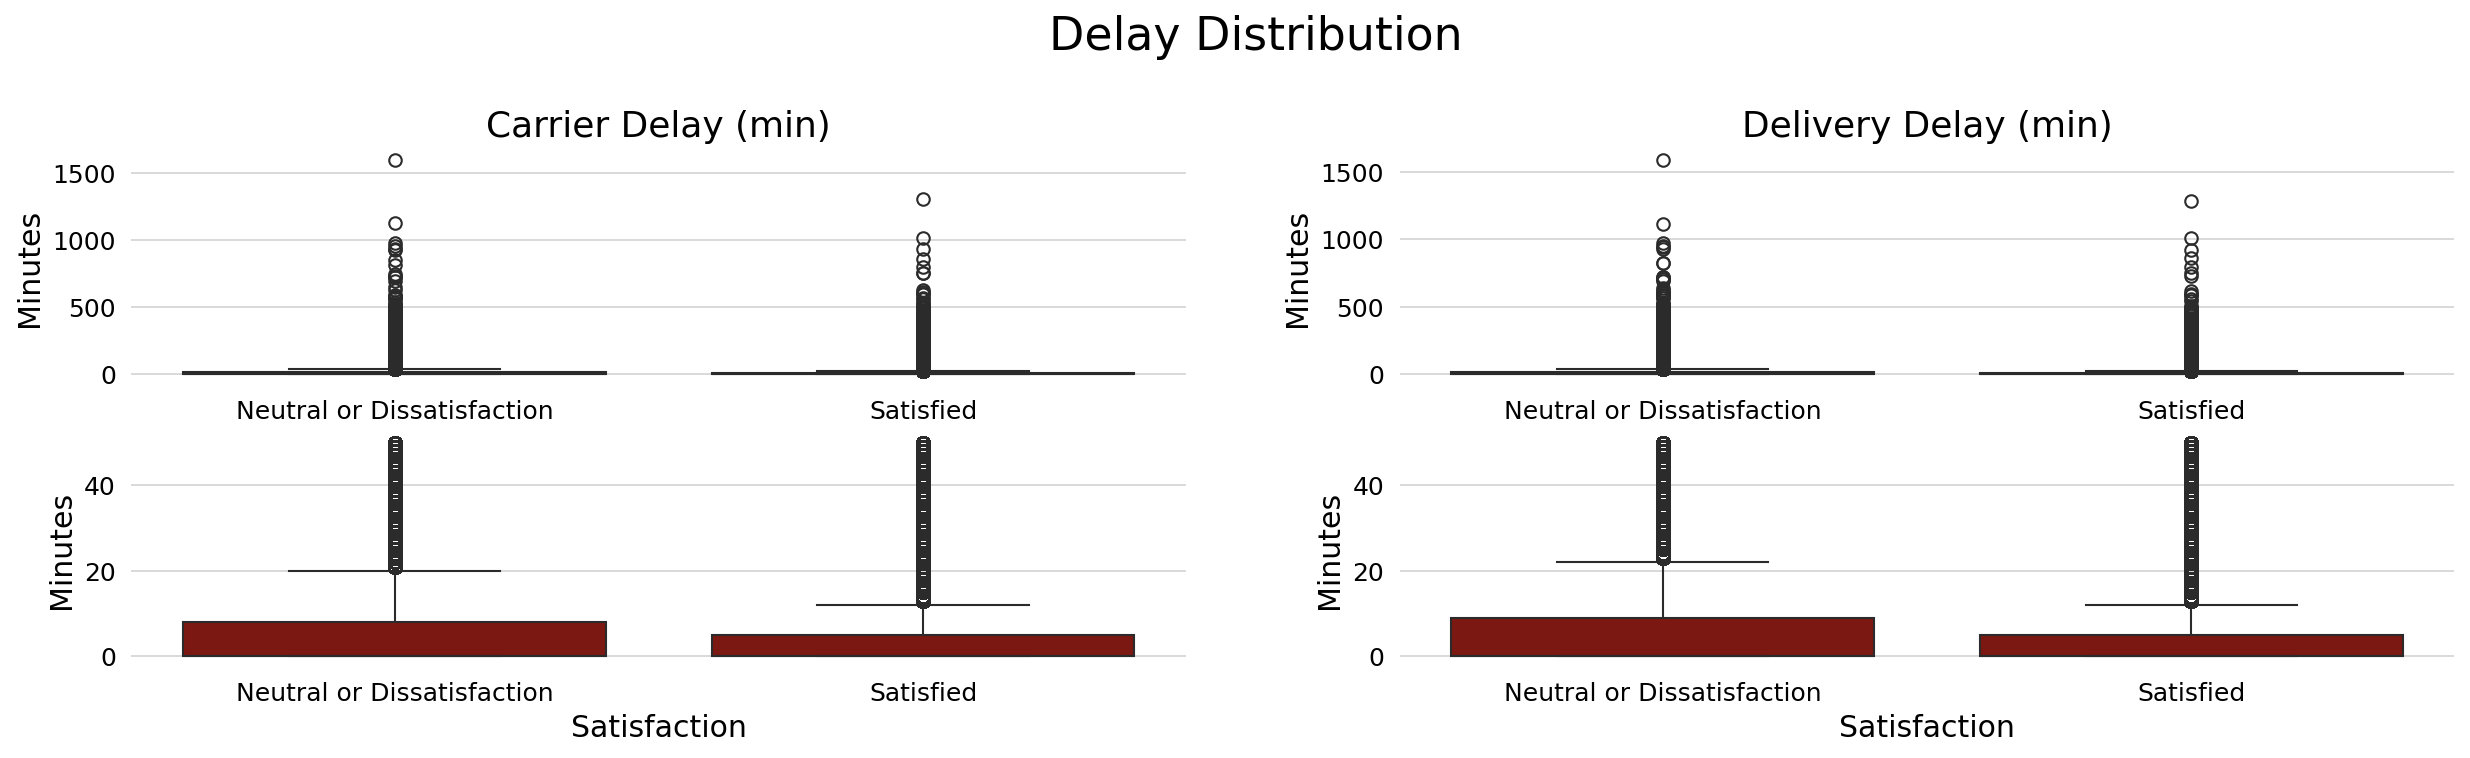

In [26]:
# Creating Figure
fig11, ax = plt.subplots(2,2)

# Data manipulation
df_delay            = df[['satisfaction', 'carrier_delay_in_minutes', 'delivery_delay_in_minutes']]
df_carrier_delay    = df_delay.loc[df_delay['carrier_delay_in_minutes'] <= 50, :]
df_delivery_delay   = df_delay.loc[df_delay['delivery_delay_in_minutes'] <= 50, :]

# Plot 1
plt.subplot(2, 2, 1)
ax1 = sns.boxplot(data = df, x = 'satisfaction', y = 'carrier_delay_in_minutes')
set_image('Carrier Delay (min)', 'Satisfaction', 'Minutes')

# Plot 2
plt.subplot(2, 2, 2)
ax2 = sns.boxplot(data = df, x = 'satisfaction', y = 'delivery_delay_in_minutes')
set_image('Delivery Delay (min)', 'Satisfaction', 'Minutes')

# Plot 3
plt.subplot(2, 2, 3)
ax3 = sns.boxplot(data = df_carrier_delay, x = 'satisfaction', y = 'carrier_delay_in_minutes')
set_image(None, 'Satisfaction', 'Minutes')

# Plot 2
plt.subplot(2, 2, 4)
ax4 = sns.boxplot(data = df_delivery_delay, x = 'satisfaction', y = 'delivery_delay_in_minutes')
set_image(None, 'Satisfaction', 'Minutes')

# Title for the main plot
fig11.suptitle('Delay Distribution', fontsize=22)

# Adjusting the space
fig11.subplots_adjust(top=0.8)

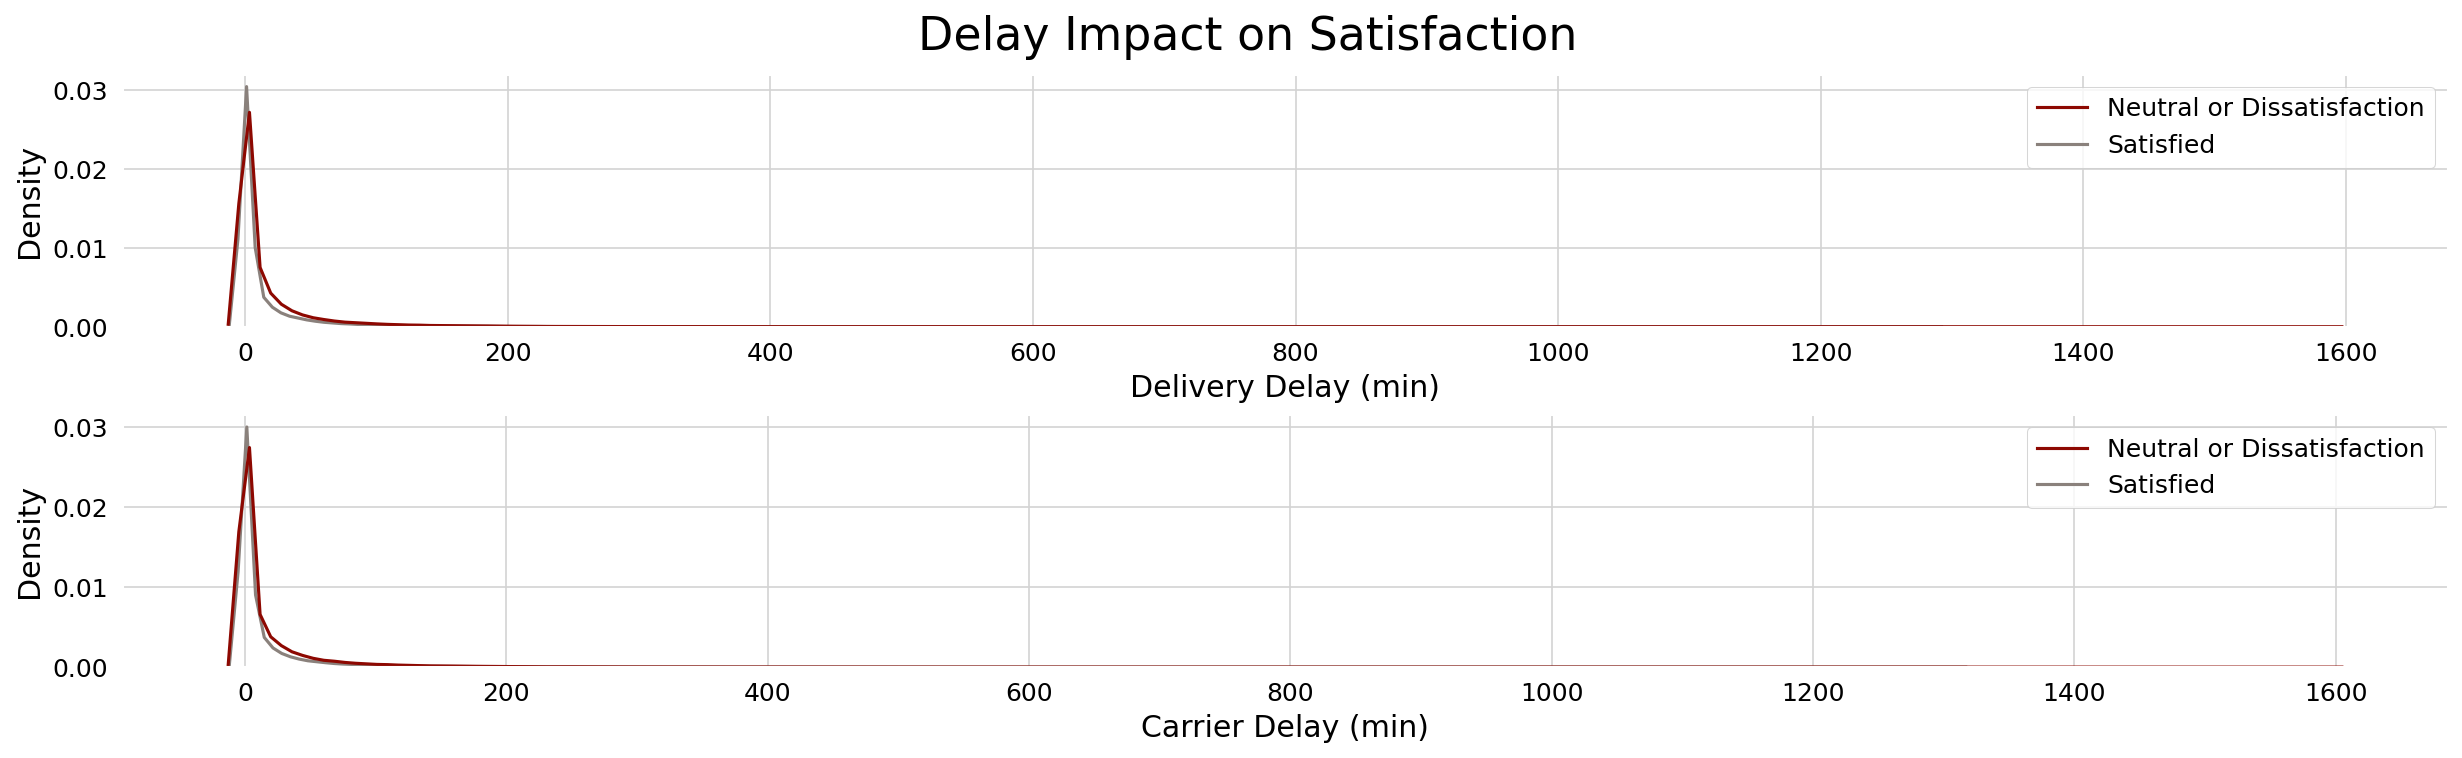

In [27]:
# Figure
fig12, axes = plt.subplots(2,1)

# Plot 1
plt.subplot(2,1,1)
ax1 = sns.kdeplot(data = df, x = 'delivery_delay_in_minutes', hue = 'satisfaction')
sns.move_legend(ax1, 'upper right', title=None)
set_image(None, 'Delivery Delay (min)', 'Density')

# Plot 2
plt.subplot(2,1,2)
ax2 = sns.kdeplot(data = df, x = 'carrier_delay_in_minutes', hue = 'satisfaction')
sns.move_legend(ax2, 'upper right', title=None)
set_image(None, 'Carrier Delay (min)', 'Density')

# Title for the main plot
fig12.suptitle('Delay Impact on Satisfaction', fontsize=22)

# Adjusting the space
fig12.subplots_adjust(top=0.9, hspace=0.35)

### 3.12. Store infrastructure and their impacts on satisfaction

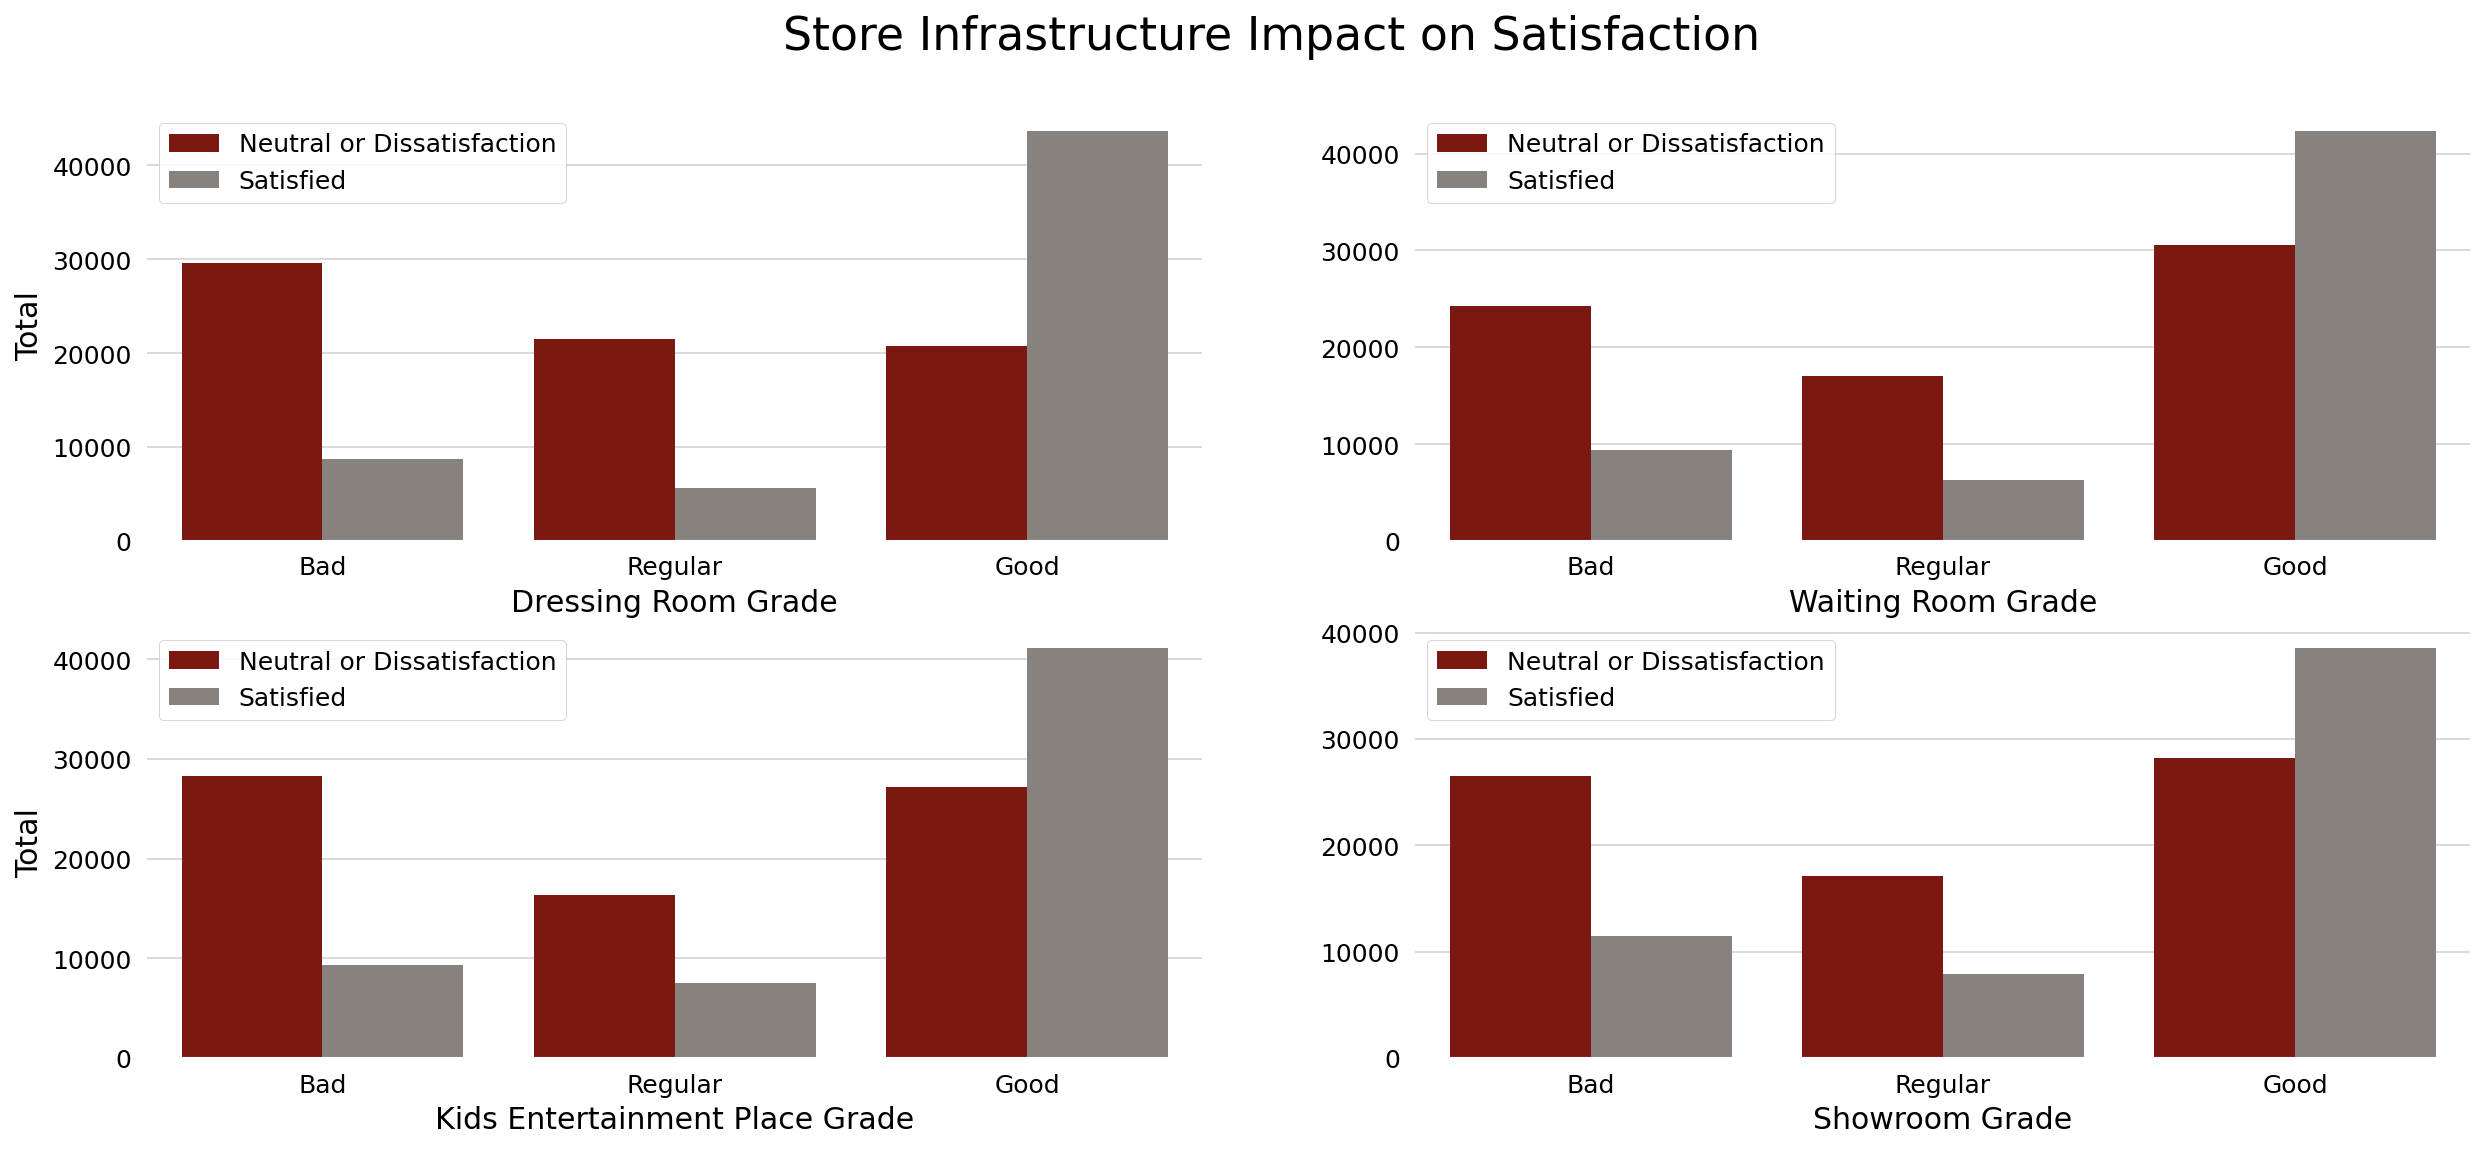

In [28]:
# Creating Figure
fig13, axes = plt.subplots(2, 2, figsize = (20, 8))

order_hue = ['Neutral or Dissatisfaction', 'Satisfied']

# Data manipulation
df_plot = df.copy()

columns_plot = ['dressing_room', 'waiting_room', 'kids_entertainment', 'showroom']

for column in columns_plot:
    df_plot[column] = df_plot[column].apply(classify_grades)

# Plot 1
plt.subplot(2, 2, 1)
ax1 = sns.countplot(data = df_plot, x = 'dressing_room', order = ['Bad', 'Regular', 'Good'], hue = 'satisfaction', hue_order = order_hue)
sns.move_legend(ax1, 'upper left', title = None)
set_image(None, 'Dressing Room Grade', 'Total')

# Plot 2
plt.subplot(2, 2, 2)
ax2 = sns.countplot(data = df_plot, x = 'waiting_room', order = ['Bad', 'Regular', 'Good'], hue = 'satisfaction', hue_order = order_hue)
sns.move_legend(ax2, 'upper left', title = None)
set_image(None, 'Waiting Room Grade', None)

# Plot 3
plt.subplot(2, 2, 3)
ax3 = sns.countplot(data = df_plot, x = 'kids_entertainment', order = ['Bad', 'Regular', 'Good'], hue = 'satisfaction', hue_order = order_hue)
sns.move_legend(ax3, 'upper left', title = None)
set_image(None, 'Kids Entertainment Place Grade', 'Total')

# Plot 4
plt.subplot(2, 2, 4)
ax4 = sns.countplot(data = df_plot, x = 'showroom', order = ['Bad', 'Regular', 'Good'], hue = 'satisfaction', hue_order = order_hue)
sns.move_legend(ax4, 'upper left', title = None)
set_image(None, 'Showroom Grade', None)

# Title for the main plot
fig13.suptitle('Store Infrastructure Impact on Satisfaction', fontsize=22)

# Adjusting the space
fig13.subplots_adjust(top=0.9)

### 3.13. EDA Conclusions

- A proporção de clientes satisfeitos é menor do que aqueles em dúvida (neutros) e insatisfeitos, mas não é muito menor no geral, pois a relação fica em 45-55%;
- A distribuição de gênero no dataset é homogênea, de maneira que mulheres são ligeiramente mais neutras/insatisfeitas que homens;
- A distribuição etária apresenta uma leve assimetria à direita, indicando que a maioria dos clientes tem menos de 40 anos. Por outro lado, a quantidade de clientes satisfeitos é maior do que os neutros/insatisfeitos para as idades entre 39 e 60 anos. Poderíamos inferir que a geração mais jovem é mais difícil de agradar ou que eles não têm uma boa experiência com a loja.
- Consumidores que compram algo para si mesmos são muito mais insatisfeitos. Por outro lado, aqueles que compram um presente se contentam mais com a experiência e a loja;
- Entre os serviços, o que mais agrada aos clientes é o dos vendedores;
- Clientes que deram notas maiores para Wi-Fi e facilidade de comprar online são mais satisfeitos;
- A partir da distância de 1500 metros, os clientes passam a ser mais satisfeitos do que insatisfeitos;
- Proporcionalmente, clientes são mais insatisfeitos nas lojas médias;
- Clientes ficam mais satisfeitos na loja grande;
- Existem muito mais clientes leais à empresa do que o contrário. Mais de 80% dos clientes são leais;
- Os clientes são mais insatisfeitos do que satisfeitos quando se trata da limpeza do ambiente.

## 4. Feature Engineering

In [29]:
# Working with df1 instead of df
df1 = df.copy()

In [30]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          129880 non-null  int64  
 1   gender                      129880 non-null  object 
 2   customer_type               129880 non-null  object 
 3   age                         129880 non-null  int64  
 4   type_of_purchase            129880 non-null  object 
 5   store_size                  129880 non-null  object 
 6   store_distance              129880 non-null  int64  
 7   in_store_wifi               129880 non-null  int64  
 8   open_close_time_convenient  129880 non-null  int64  
 9   easy_of_online_shopping     129880 non-null  int64  
 10  store_location              129880 non-null  int64  
 11  toilet_cleaning             129880 non-null  int64  
 12  dressing_room               129880 non-null  int64  
 13  waiting_room  

Como visto acima, existem 5 características categóricas que precisam ser codificadas e 1 característica numérica com valores faltantes que precisam ser imputados. Esses procedimentos serão realizados nas seções seguintes.

### 4.1. Encoding

In [31]:
# Encoding categorical values 
columns_encoder(df1)

### 4.3. Train Test Split

In [32]:
# Defining the features (X) and target variable (y)
X = df1.drop('satisfaction', axis=1)
y = df1['satisfaction']

# Split the data into training and remaining data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=SEED)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=SEED)

In [33]:
for i, j in zip(['X_train', 'X_test', 'X_val'], [X_train, X_test, X_val]):
    print(i)
    df_shape(j)
    print()

X_train
Number of rows: 90,916
Number of columns: 23

X_test
Number of rows: 19,482
Number of columns: 23

X_val
Number of rows: 19,482
Number of columns: 23



### 4.3. Handling NaN Values

In [34]:
# KNN Imputer for missing values
X_train = knn_imputer(X_train)
X_test  = knn_imputer(X_test)
X_val   = knn_imputer(X_val)

### 4.5. Scaling

Existem 4 variáveis numéricas que precisam ser dimensionadas. As colunas `age` e `store_distance` serão dimensionadas usando **MinMaxScaler** e as colunas `delivery_delay_in_ Minutes` e `carrier_delay_in_ Minutes` serão dimensionadas usando **RobustScaler** porque essas variáveis possuem uma ampla gama de *outliers*.

In [35]:
# Columns to scale
mm_columns  = ['age', 'store_distance']
rs_columns  = ['delivery_delay_in_minutes', 'carrier_delay_in_minutes']

# Scalers
mms_scaler  = MinMaxScaler()
rs_scaler   = RobustScaler()

# Scaling for X_train
X_train = scaling_columns(X_train, mm_columns, mms_scaler)
X_train = scaling_columns(X_train, rs_columns, rs_scaler)

# Scaling for X_test
X_test = scaling_columns(X_test, mm_columns, mms_scaler)
X_test = scaling_columns(X_test, rs_columns, rs_scaler)

# Scaling for X_val
X_val = scaling_columns(X_val, mm_columns, mms_scaler)
X_val = scaling_columns(X_val, rs_columns, rs_scaler)

### 4.6. Features Selection

In [36]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)

# Fit the model
rf.fit(X_train, y_train)

# Feature importance
rf.feature_importances_

# Feature Ranking
feat_rank = pd.DataFrame()

for i, j in zip(X_train, rf.feature_importances_):
    aux = pd.DataFrame( {'Feature': i, 'Importance': j}, index=[0])
    feat_rank = pd.concat([feat_rank, aux], axis=0)

# Displaying the feature ranking DataFrame
feat_rank.reset_index(drop=True).sort_values('Importance', ascending=False)

,Feature,Importance
12,dressing_room,0.222
7,in_store_wifi,0.138
5,store_size,0.130
4,type_of_purchase,0.129
14,kids_entertainment,0.074
13,waiting_room,0.053
16,showroom,0.040
9,easy_of_online_shopping,0.035
2,customer_type,0.032
15,seller_service,0.024


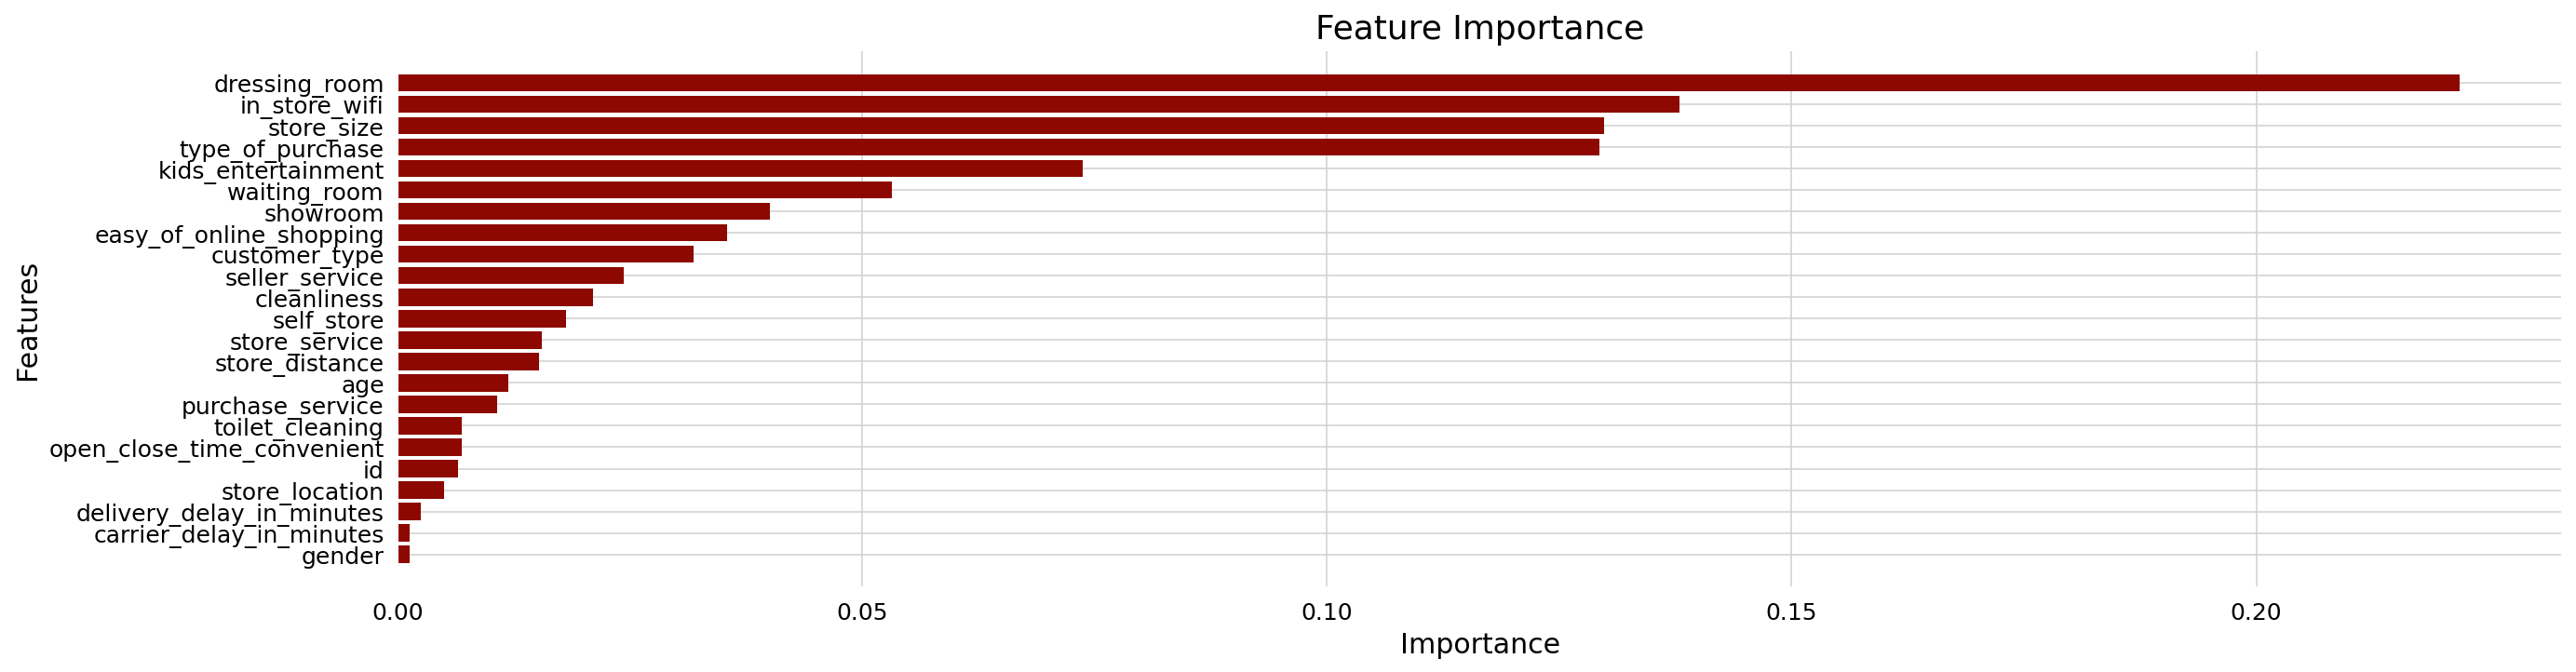

In [37]:
# Features sorted by their score
sorted_features = rf.feature_importances_.argsort()

# Plot
plt.barh(X_train.columns[sorted_features], rf.feature_importances_[sorted_features])

# Settings for plot
set_image('Feature Importance', 'Importance', 'Features')

In [38]:
selected_cols = [
    # 'id',
    # 'gender',
    'customer_type',
    'age',
    'type_of_purchase',
    'store_size',
    'store_distance',
    'in_store_wifi',
    'open_close_time_convenient',
    'easy_of_online_shopping',
    'store_location',
    'toilet_cleaning',
    'dressing_room',
    'waiting_room',
    'kids_entertainment',
    'seller_service',
    'showroom',
    'self_store',
    'purchase_service',
    'store_service',
    'cleanliness',
    # 'carrier_delay_in_minutes',
    # 'delivery_delay_in_minutes'
]

In [39]:
# Applying to train
X_train = X_train[selected_cols]

# Applying to test
X_test  = X_test[selected_cols]

# Applying to val
X_val   = X_val[selected_cols]

## 5. Machine Learning

### 5.1. Logistic Regression

In [40]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=SEED)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

In [41]:
# Metrics for Logistic Regression
model_report('Logistic Regression', y_test, y_pred)

Model Name: Logistic Regression
Accuracy: 0.7979
Precision: 0.7919
Recall: 0.7407
F1 Score: 0.7654
Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.84      0.82     10809
           1       0.79      0.74      0.77      8673

    accuracy                           0.80     19482
   macro avg       0.80      0.79      0.79     19482
weighted avg       0.80      0.80      0.80     19482



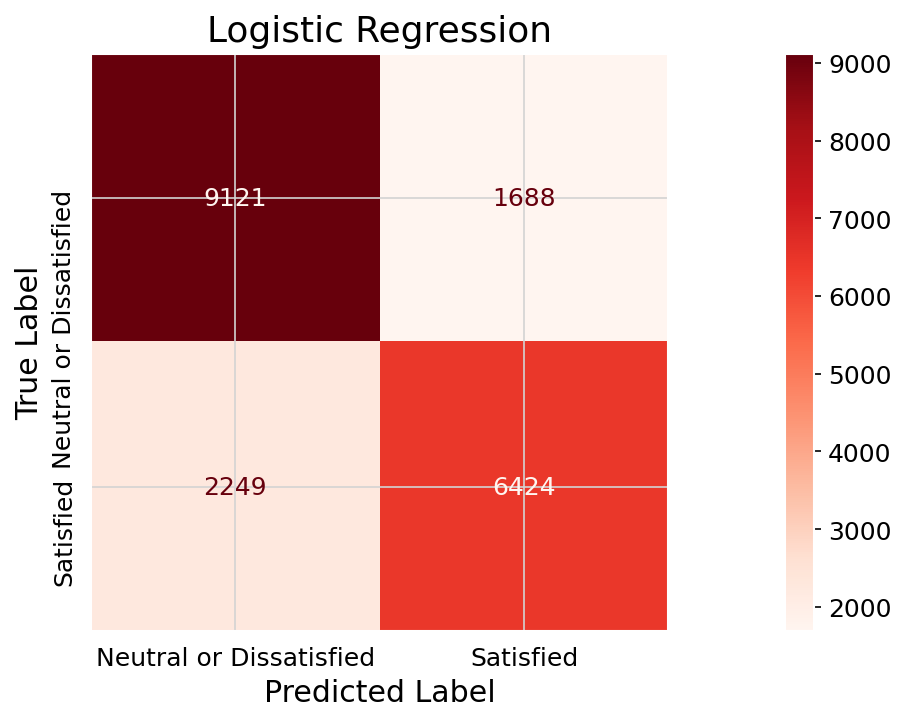

In [42]:
# Confusion Matrix for Logistic Regression
CM('Logistic Regression', y_test, y_pred)

### 5.2. Random Forest

In [43]:
# Random Forest
rf = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=SEED)

# Fit the classifier to the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

In [44]:
# Metrics for Random Forest
model_report('Random Forest', y_test, y_pred)

Model Name: Random Forest
Accuracy: 0.8412
Precision: 0.8353
Recall: 0.8012
F1 Score: 0.8179
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.87      0.86     10809
           1       0.84      0.80      0.82      8673

    accuracy                           0.84     19482
   macro avg       0.84      0.84      0.84     19482
weighted avg       0.84      0.84      0.84     19482



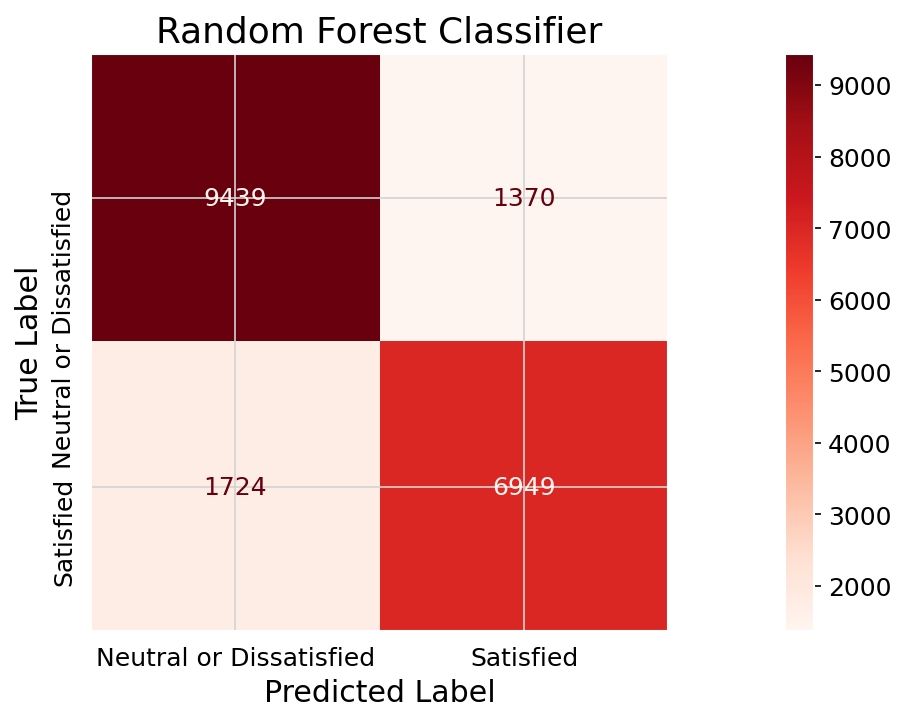

In [45]:
# Confusion Matrix for Random Forest
CM('Random Forest Classifier', y_test, y_pred)

### 5.3. XGBoost

In [46]:
# Parameters Setting
params = {
    'objective': 'binary:logistic',
    'n_estimators': 1000,
    'max_depth': 5,
    'min_child_weight': 1,
    'subsample': 0.5,
    'gamma': 0.1,
    'learning_rate': 0.01,
    'random_state': SEED
}

# Create an XGBoost classifier
model = XGBClassifier(**params)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

In [47]:
# Metrics for XGBoost
model_report('XGBoost', y_test, y_pred)

Model Name: XGBoost
Accuracy: 0.8643
Precision: 0.8681
Recall: 0.8198
F1 Score: 0.8433
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.90      0.88     10809
           1       0.87      0.82      0.84      8673

    accuracy                           0.86     19482
   macro avg       0.86      0.86      0.86     19482
weighted avg       0.86      0.86      0.86     19482



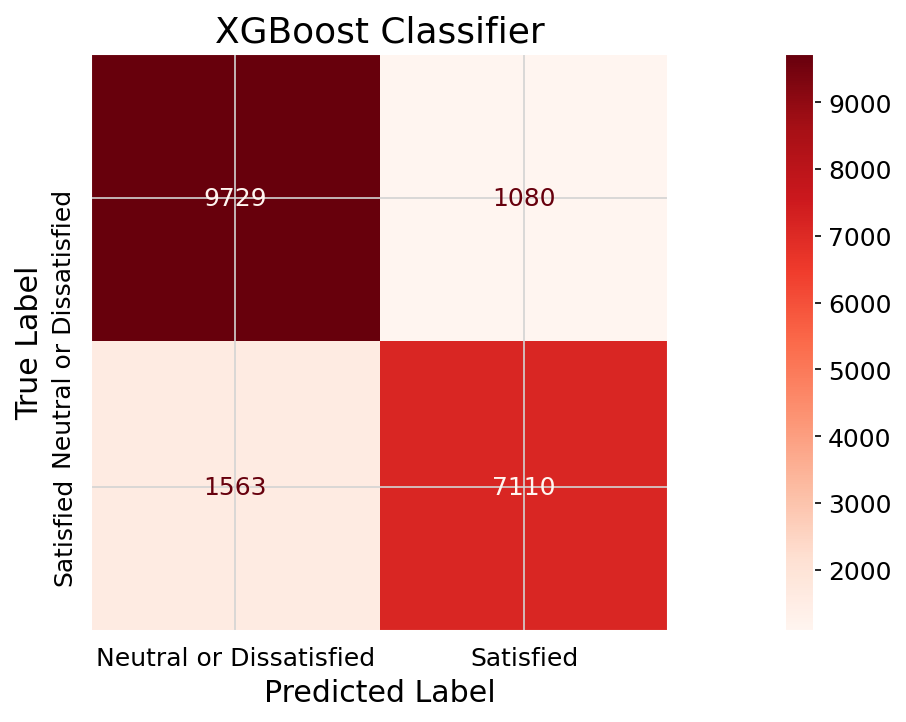

In [48]:
# Confusion Matrix for XGBoost
CM('XGBoost Classifier', y_test, y_pred)

### 5.4. LightGBM

In [49]:
# Parameters Setting
params = {
    'n_estimators': 1000,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 64,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'random_state': SEED
}

# Create a LightGBM classifier with the specified parameters
lgbm_model = LGBMClassifier(**params)

# Train the model
lgbm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

In [50]:
# Metrics for LightGBM
model_report('LightGBM Classifier', y_test, y_pred)

Model Name: LightGBM Classifier
Accuracy: 0.8643
Precision: 0.8681
Recall: 0.8198
F1 Score: 0.8433
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.90      0.88     10809
           1       0.87      0.82      0.84      8673

    accuracy                           0.86     19482
   macro avg       0.86      0.86      0.86     19482
weighted avg       0.86      0.86      0.86     19482



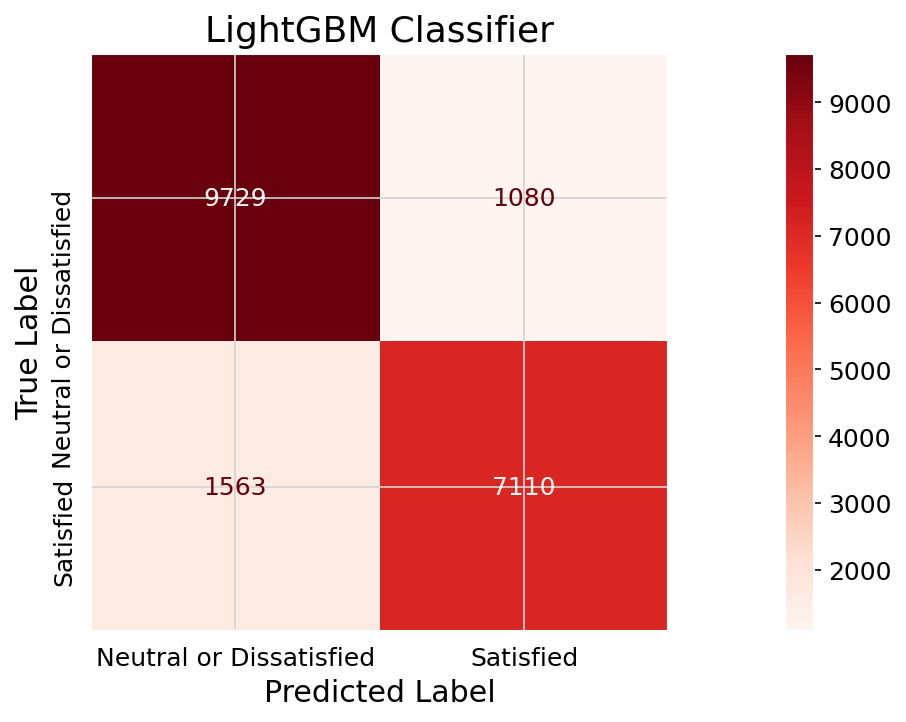

In [51]:
# Confusion Matrix
CM('LightGBM Classifier', y_test, y_pred)

#### 5.4.1. LightGBM Cross Validation

In [52]:
# Cross Validation with LightGBM
results = CV(lgbm_model, X_train, y_train)

# Metrics for LightGBM CV
CV_metrics('LightGBM Classifier', results)

Model Name: LightGBM Classifier
Accuracy: 0.8644242957027855
Precision: 0.8676399395538248
Recall: 0.8211871407440899
F1 Score: 0.8437719552086392


Os resultados do Cross-Validation não apresentam melhoras significativas nas métricas em comparação com o modelo LightGBM testado anteriormente. 

### 5.5. Hyperparameter Tuning 

In [53]:
# Model
model = LGBMClassifier()

# Hyperparameter space
param_dist = {
    'n_estimators': [750, 1000, 1200],
    'objective': ['binary'],
    'metric': ['binary_logloss'],
    'boosting_type': ['gbdt'],
    'num_leaves': [32, 64, 128],
    'max_depth': [-1, 5, 10],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'learning_rate': [0.01, 0.05, 0.1],
    'random_state': [SEED]}

# RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=8, scoring='accuracy', cv=5, random_state=SEED)

# Fitting the model
random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Best model
best_model = random_search.best_estimator_

# Predictions result
y_pred = best_model.predict(X_test)

Best Parameters: {'subsample': 0.9, 'random_state': 42, 'objective': 'binary', 'num_leaves': 128, 'n_estimators': 750, 'min_child_samples': 30, 'metric': 'binary_logloss', 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.5, 'boosting_type': 'gbdt'}


In [54]:
# Metrics for LightGBM
model_report('LightGBM Classifier - RandomizedSearchCV', y_test, y_pred)

Model Name: LightGBM Classifier - RandomizedSearchCV
Accuracy: 0.8693
Precision: 0.8769
Recall: 0.8219
F1 Score: 0.8485
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.91      0.89     10809
           1       0.88      0.82      0.85      8673

    accuracy                           0.87     19482
   macro avg       0.87      0.86      0.87     19482
weighted avg       0.87      0.87      0.87     19482



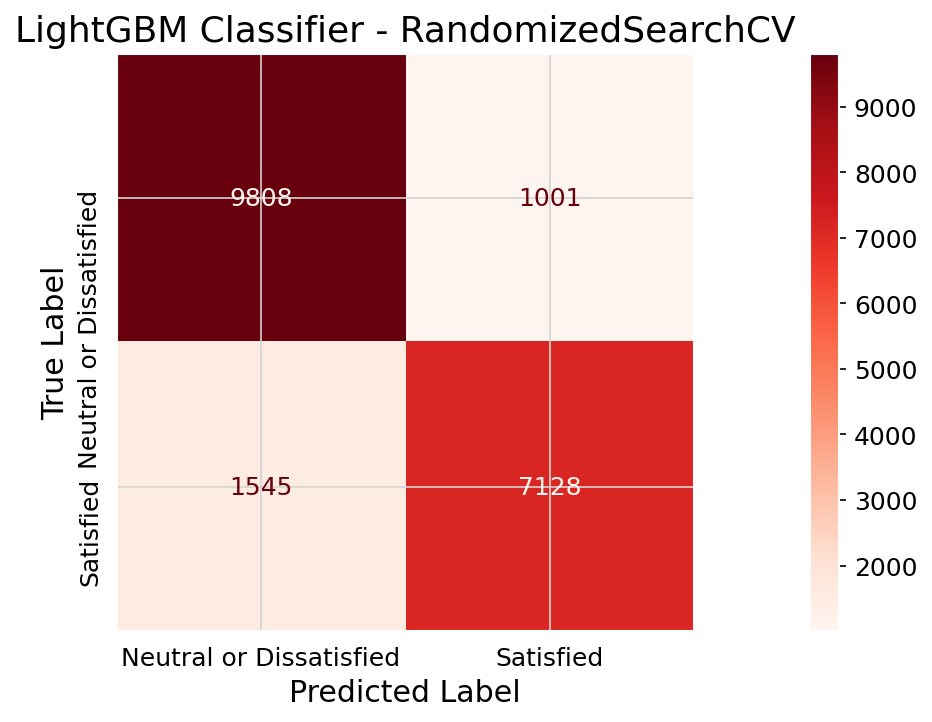

In [55]:
# Confusion Matrix
CM('LightGBM Classifier - RandomizedSearchCV', y_test, y_pred)

### 5.6. Validation

In [56]:
# Predictions result
y_pred = best_model.predict(X_val)

# Metrics for LightGBM on X_val
model_report('LightGBM Classifier - Validation', y_val, y_pred)

Model Name: LightGBM Classifier - Validation
Accuracy: 0.871
Precision: 0.8772
Recall: 0.8296
F1 Score: 0.8528
Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.90      0.89     10706
           1       0.88      0.83      0.85      8776

    accuracy                           0.87     19482
   macro avg       0.87      0.87      0.87     19482
weighted avg       0.87      0.87      0.87     19482



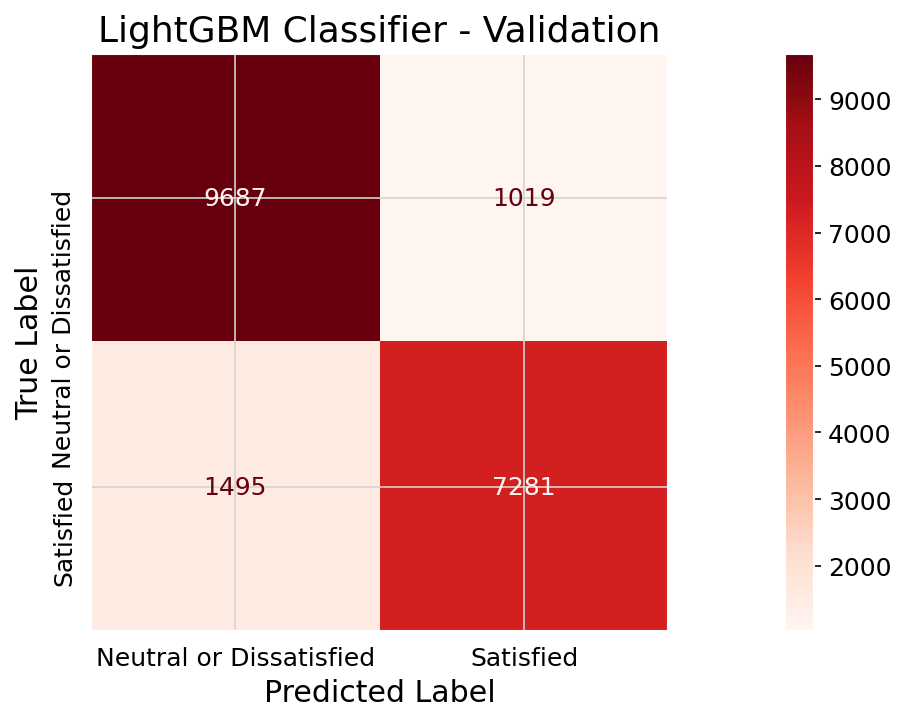

In [57]:
# Confusion Matrix
CM('LightGBM Classifier - Validation', y_val, y_pred)

## 6. Conclusions

### Impacto Estratégico da Solução

A implementação do modelo de Machine Learning para classificar a satisfação do cliente na InStyle marca uma virada estratégica significativa. O foco na satisfação do cliente não apenas aborda desafios cruciais da empresa, mas também redefine a abordagem para aprimorar a experiência do cliente e consolidar sua posição no mercado de moda.

### Benefícios Tangíveis

1. **Elevação da Satisfação do Cliente:**
- Identificar clientes insatisfeitos ou neutros permite à equipe de atendimento abordá-los de maneira personalizada, atendendo às suas preocupações e oferecendo soluções.
- Essa prática não apenas melhora a satisfação do cliente, mas também reduz queixas, contribuindo para aprimorar a reputação da InStyle.

2. **Fidelização e Retenção de Clientes:**
- O modelo de classificação de clientes possibilita ações proativas para resolver as causas de insatisfação, promovendo o retorno desses clientes para futuras compras.
- Fortalecer os laços empresa-cliente não só fideliza consumidores a longo prazo, mas também amplia o valor do ciclo de vida do cliente.

3. **Direcionamento Eficiente de Marketing:**
- O modelo orienta a equipe de marketing na direção certa, concentrando esforços em públicos mais propensos a se tornarem clientes satisfeitos e leais, ou revertendo situações de insatisfação.

4. **Otimização de Custos:**
- A identificação aprimorada de clientes reduz os custos operacionais ao permitir que a empresa entre em contato de maneira mais focada, otimizando o tempo de funcionários de outros setores.

### Avaliação da Precisão do Modelo
- Os resultados alcançados, com uma *Precision* acima de 87% e *F1 Score* de 85%, refletem uma implementação bem-sucedida do modelo nos conjuntos de treino-teste e também no de validação. 
- Ao considerar os resultados de validação, a abordagem de contatar clientes classificados como "Neutro ou Insatisfeito" mostra uma taxa de erro inferior a 14% na oferta de crédito, descontos ou promoções.

### Considerações para o Futuro

Embora o resultado final, com uma taxa de acerto superior a 86%, seja positivo para a empresa, a empresa reconhece o potencial para melhorias contínuas. A obtenção de mais dados, a expansão do poder computacional e um investimento adicional de tempo são cruciais para aprimorar ainda mais o modelo e garantir o aprimoramento das operações.

### Além do Modelo de Machine Learning

É essencial ressaltar que o modelo de Machine Learning não é o fim, mas sim um meio para alcançar o verdadeiro objetivo: a compreensão aprofundada dos clientes e seus comportamentos, especialmente aqueles insatisfeitos. **O foco final é a melhoria contínua do serviço da InStyle, fortalecendo as relações com os clientes e garantindo sua retenção a longo prazo.**

A implementação bem-sucedida do projeto não apenas aborda os desafios atuais da empresa, mas também estabelece uma base sólida para o aprimoramento constante da experiência do cliente e o crescimento sustentável da InStyle no mercado competitivo da moda.